# **Analiza preferencji użytkowników serwisu Filmweb**

# 1\. Wczytanie danych i niezbędnych bibliotek

Poniższa część projektu polega na analizie eksploracyjnej wcześniej utworzonej bazy danych filmów z portalu Filmweb, które zostały ocenione przez minimum 500 użytkowników. Analiza będzie skupiać się na badaniu wpływu różnych czynników na końcową średnią ocenę filmu. Poszukam odpowiedzi na następujące pytania:

* W jaki sposób użytkownicy korzystają ze skali ocen 1-10 i jak rozkładają się średnie oceny filmów użytkowników i krytyków.
* Jak wygląda podział bazy danych na kategorie, czyli jakie rodzaje filmów są w Polsce popularne.
* Jaki jest wpływ roku i kraju produkcji oraz gatunku na ocenę filmu. 
* Jaka jest korelacja między budżetem, box office i oceną filmu.

## 1.1 Przygotowanie środowiska

Na początku importuję biblioteki, których będę używać w dalszej części analizy. Biblioteka *scipy* zawiera narzędzia matematyczne w tym     moduł statystyczny *stats*.  Do tworzenia wykresów zdecydowałam się na bibliotekę *seaborn*, która bazuje na *matplotlib* poszerzając jej możliwości i upraszczając składnię. Pozwala nam na ustawienie stylu dla kolejnych wykresów dla spójnego wyglądu. Do stwozenia wykresów dynamicznych użyję *plotly.express*. Biblioteka *fitter* ma narzędzie pozwalające na automatyczne szukanie najlepiej pasującego rozkładu do danych, wyznaczenie jego parametrów i przeprowadzenie dla nich testu Kołmogorowa-Smirnowa.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew, kurtosis
from fitter import Fitter, get_common_distributions, get_distributions
import plotly.express as px

sns.set_theme(style="whitegrid")

## 1.2 Wczytanie danych

Importujemy dane z pliku typu CSV, który utworzyłam wcześniej poprzez scraping polskiego serwisu filmweb.pl. Sprawdzam rozmiar danych i nazwy kolumn.

In [2]:
df = pd.read_csv("filmweb.csv", encoding="utf-8", header=0, sep=";")
print(str(df.shape[0]), "wierszy")
print(str(df.shape[1]), "kolumn")

15966 wierszy
30 kolumn


In [3]:
df.columns

Index(['ID', 'Tytuł', 'Tytuł org.', 'Rok', 'Długość', 'Ocena', 'Liczba ocen',
       'Najlepsza ocena', 'Najgorsza ocena', 'Chce zobaczyć', 'Ocena krytyków',
       'Liczba ocen krytyków', 'Reżyser', 'Scenariusz', 'Gatunek', 'Kraj',
       'Box Office', 'Budżet', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', 'Wątki', 'Odpowiedzi'],
      dtype='object')

Następnie przyglądam się, jak wyglądają poszczególne obserwacje, aby sprawdzić, czy dane zostały wczytane prawidłowo. Transponuję je ze względu na dużą liczbę kolumn.

In [4]:
df.head(5).T

0               1  \
ID                                        1047             837   
Tytuł                          Milczenie owiec  Podziemny krąg   
Tytuł org.            The Silence of the Lambs      Fight Club   
Rok                                       1991            1999   
Długość                                    118             139   
Ocena                                  8.24219         8.28509   
Liczba ocen                             673204          614177   
Najlepsza ocena                             10              10   
Najgorsza ocena                              1               1   
Chce zobaczyć                            81570           85302   
Ocena krytyków                         8.48276         8.19355   
Liczba ocen krytyków                      29.0            31.0   
Reżyser                         Jonathan Demme   David Fincher   
Scenariusz                           Ted Tally        Jim Uhls   
Gatunek                               Thriller        Thriller   
Kraj                                       USA             USA   
Box Office                         130742922.0      37030102.0   
Budżet                              19000000.0      63000000.0   
1                                         5590            3946   
2                                         2627            1958   
3                                         4222            4598   
4                                         6856            6961   
5                                        14139           15604   
6                                        28976           30371   
7                                        85360           75858   
8                                       206849          163554   
9                                       184975          173945   
10                                      133610          137382   
Wątki                                     1029            1729   
Odpowiedzi                                4229            9042   

                                       2                  3  \
ID                                   825             500891   
Tytuł                       Szósty zmysł           Incepcja   
Tytuł org.               The Sixth Sense          Inception   
Rok                                 1999               2010   
Długość                              107                148   
Ocena                            7.80946            8.24992   
Liczba ocen                       625842             608743   
Najlepsza ocena                       10                 10   
Najgorsza ocena                        1                  1   
Chce zobaczyć                      68757              65175   
Ocena krytyków                   7.63636                8.0   
Liczba ocen krytyków                22.0               28.0   
Reżyser               M. Night Shyamalan  Christopher Nolan   
Scenariusz            M. Night Shyamalan  Christopher Nolan   
Gatunek                         Thriller    Surrealistyczny   
Kraj                                 USA                USA   
Box Office                   293506292.0        292587330.0   
Budżet                        40000000.0        160000000.0   
1                                   4334               1319   
2                                   2263               1049   
3                                   4849               3118   
4                                   9541               4432   
5                                  22498              12152   
6                                  52106              28788   
7                                 125015              87839   
8                                 202951             188739   
9                                 120770             179759   
10                                 81515             101548   
Wątki                                784               2871   
Odpowiedzi                          1741              25655   

                                        4  


# 2\. Wstępne przygotowanie danych

## 2.1 Usuwanie duplikatów i sprawdzanie typów danych

Na początku upewniam się, czy zbiór danych nie zawiera pustych wierszy oraz duplikatów i pokażę rozmiar analizowanego zbioru danych. W procesie zbierania danych ze strony internetowej kod został napisany w taki sposób, żeby pozbyć się ewentualnych powtórzeń danych oraz wartości pustych. W tej części sprawdzam, czy na pewno zadziałał on poprawnie. Duplikaty zweryfikuję na podstawie kolumny "ID".

In [5]:
# usunięcie pustych wierszy
df["ID"] = pd.to_numeric(df["ID"], downcast="integer")
df = df.loc[df["ID"] != 0]
print(f"Rozmiar po usunięciu pustych wierszy: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")

# usnięcie duplikatów
df.drop_duplicates(subset=["ID"], inplace=True)
print(f"Rozmiar po usunięciu duplikatów: {df.shape[0]} wierszy, {df.shape[1]} kolumn.")

Rozmiar po usunięciu pustych wierszy: 15966 wierszy, 30 kolumn.
Rozmiar po usunięciu duplikatów: 15966 wierszy, 30 kolumn.


Na początku zbiór danych miał 15966 wierszy i 30 kolumn. Po usunięciu duplikatów oraz pustych wierszy jego rozmiar nie uległ zmianie, więc wszystkie dane zostały zebrane poprawnie podczas scrapingu. Wszystkie ID filmów są unikatowe, nie można jednak wykluczyć możliwości popełnienia błędu przez użytkowników serwisu, którzy mogli dodać istniejący już film. Porównam zatem filmy potencjalnie podejrzane, czyli takie, które mają jednakowe tytuły oryginalne i rok produkcji.

In [6]:
df[df.duplicated(subset=["Tytuł org.", "Rok"], keep=False) == True].sort_values("Tytuł org.")[["Tytuł","Tytuł org.","Rok","Gatunek","Reżyser","Kraj","Długość"]]

Tytuł                          Tytuł org.  \
9308                               Brat                             Brother   
2208                            Brother                             Brother   
14313                   Zbrodnia i kara                Crime and Punishment   
14749                   Zbrodnia i kara                Crime and Punishment   
9808                            Ecstasy                             Ecstasy   
15321                           Ecstasy                             Ecstasy   
1685   Ghost in the Shell 2: Niewinność                           Innocence   
14710                        Niewinność                           Innocence   
4188                       Joanna d'Arc                         Joan of Arc   
1639                       Joanna d'Arc                         Joan of Arc   
6008            Podróż do wnętrza Ziemi  Journey to the Center of the Earth   
11439           Podróż do wnętrza Ziemi  Journey to the Center of the Earth   
3433                             Miłość                              Miłość   
2783                             Miłość                              Miłość   
8500                              Skóra                                Skin   
9678                              Skóra                                Skin   
13135                              Skin                                Skin   
13649                              Skin                                Skin   

        Rok            Gatunek                Reżyser             Kraj Długość  
9308   2000           Animacja            Adam Elliot        Australia       8  
2208   2000        Gangsterski         Takeshi Kitano          Japonia     114  
14313  2002             Dramat         Julian Jarrold  Wielka Brytania     200  
14749  2002             Dramat          Menahem Golan              USA     120  
9808   2011         Melodramat          Robert Heydon           Kanada      99  
15321  2011             Dramat                    Lux           Kanada      96  
1685   2004             Sci-Fi           Mamoru Oshii          Japonia     100  
14710  2004             Dramat  Lucile Hadzihalilovic          Francja     115  
4188   1999       Biograficzny       Christian Duguay           Kanada   140.0  
1639   1999       Biograficzny             Luc Besson          Francja     152  
6008   2008         Przygodowy            Eric Brevig              USA      92  
11439  2008         Przygodowy             T.J. Scott              USA      90  
3433   2012       Biograficzny      Filip Dzierżawski           Polska    92.0  
2783   2012  Dramat obyczajowy       Sławomir Fabicki           Polska     105  
8500   2018             Dramat             Guy Nattiv              USA      20  
9678   2008       Biograficzny         Anthony Fabian  Wielka Brytania     107  
13135  2008             Dramat         Hanro Smitsman         Holandia      85  
13649  2018             Dramat             Guy Nattiv              USA     110

Po analizie pozostałych danych na temat powyższych filmów stwierdzam, że są to unikatowe pozycje. Nawet jeśli mają ten sam tytuł oryginalny i rok to różni je reżyser, gatunek, kraj czy długość.

Następnie przyjrzę się zbiorowi danych i podstawowym informacjom na ich temat. Sprawdzę, czy poprawnie zostały rozpoznane typy danych dla wszystkich kolumn.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15966 entries, 0 to 15965
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    15966 non-null  int32  
 1   Tytuł                 15966 non-null  object 
 2   Tytuł org.            15966 non-null  object 
 3   Rok                   15966 non-null  int64  
 4   Długość               15964 non-null  object 
 5   Ocena                 15966 non-null  float64
 6   Liczba ocen           15966 non-null  int64  
 7   Najlepsza ocena       15966 non-null  int64  
 8   Najgorsza ocena       15966 non-null  int64  
 9   Chce zobaczyć         15966 non-null  int64  
 10  Ocena krytyków        10571 non-null  float64
 11  Liczba ocen krytyków  10571 non-null  float64
 12  Reżyser               15911 non-null  object 
 13  Scenariusz            15325 non-null  object 
 14  Gatunek               15966 non-null  object 
 15  Kraj               

Wyświetlam nazwy kolumn zawierające dane kategorialne i numeryczne.

In [8]:
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
print("Dane kategorialne:", categorical_columns)
numerical_columns = df.select_dtypes(exclude=["object"]).columns.tolist()
print("Dane numeryczne:", numerical_columns)

Dane kategorialne: ['Tytuł', 'Tytuł org.', 'Długość', 'Reżyser', 'Scenariusz', 'Gatunek', 'Kraj']
Dane numeryczne: ['ID', 'Rok', 'Ocena', 'Liczba ocen', 'Najlepsza ocena', 'Najgorsza ocena', 'Chce zobaczyć', 'Ocena krytyków', 'Liczba ocen krytyków', 'Box Office', 'Budżet', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Wątki', 'Odpowiedzi']


W danych kategorialnych pojawia się długość, która powinna być daną numeryczną. Wyświetlam wartości, które nie są numeryczne lub są NaN w kolumnie "Długość".

In [9]:
print(df[pd.to_numeric(df["Długość"], errors="coerce").isnull()]["Długość"])

4354                NaN
4388                NaN
6248     $film.duration
6391     $film.duration
8191     $film.duration
10279    $film.duration
10870    $film.duration
11908    $film.duration
14895    $film.duration
Name: Długość, dtype: object


Należy zatem przekonwertować te dane, które nie zostały uznane jako numeryczne, a jeśli nie jest to możliwe, to w miejsce aktualnej wartości przypisać NaN za pomocą parametru coerce. Po zmianie wyświetlam informacje dotyczące tej kolumny.

In [10]:
df["Długość"] = pd.to_numeric(df["Długość"], errors="coerce", downcast="float")
df["Długość"].info()

<class 'pandas.core.series.Series'>
Int64Index: 15966 entries, 0 to 15965
Series name: Długość
Non-Null Count  Dtype  
--------------  -----  
15957 non-null  float32
dtypes: float32(1)
memory usage: 187.1 KB


Typ danych jest już poprawnie określony, zatem aktualizuję definicje kolumn kategorialne i numerycznych. W dalszej części zajmę się analizą poszczególnych zmiennych.

In [11]:
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
print("Dane kategorialne:", categorical_columns)
numerical_columns = df.select_dtypes(exclude=["object"]).columns.tolist()
print("Dane numeryczne:", numerical_columns)

Dane kategorialne: ['Tytuł', 'Tytuł org.', 'Reżyser', 'Scenariusz', 'Gatunek', 'Kraj']
Dane numeryczne: ['ID', 'Rok', 'Długość', 'Ocena', 'Liczba ocen', 'Najlepsza ocena', 'Najgorsza ocena', 'Chce zobaczyć', 'Ocena krytyków', 'Liczba ocen krytyków', 'Box Office', 'Budżet', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Wątki', 'Odpowiedzi']


## 2.2. Brakujące dane i podstawowe statystyki

Wyświetlam liczbę brakujących danych w kolumnach, w których występują.

In [12]:
df.isna().sum()[df.isna().sum() > 0]

Długość                     9
Ocena krytyków           5395
Liczba ocen krytyków     5395
Reżyser                    55
Scenariusz                641
Kraj                       11
Box Office              10360
Budżet                  12314
dtype: int64

In [13]:
for col in df.columns:
    percent_missing = np.mean(df[col].isna())*100
    if percent_missing > 0:
        print("{} - {:0.2f}%".format(col, percent_missing))

Długość - 0.06%
Ocena krytyków - 33.79%
Liczba ocen krytyków - 33.79%
Reżyser - 0.34%
Scenariusz - 4.01%
Kraj - 0.07%
Box Office - 64.89%
Budżet - 77.13%


Jest 8 kolumn, w których dane są niepełne, aczkolwiek nie są one niezbędne do wszystkich analiz. Na tym etapie nie będę usuwać tych wierszy, będę to robić lokalnie w momencie badania zależności czy statystyk dotyczących konkretnych kategorii.

Następnie za pomocą funkcji **describe** wyliczam statystyki opisowe dla danych numerycznych. W wyniku działania funkcji otrzymujemy tabelę zawierającą liczbę niepustych wartości, średnią, odchylenie standardowe, minimum, pierwszy kwartyl, medianę, trzeci kwartyl oraz maksimum. Poniżej znajduje się kod służący zmianie formatowania kolumn wyświetlanych przez funkcję **describe**, tak aby wartości charakterystyk statystycznych dla kolumn "Ocena" oraz "Ocena krytyków" wyświetlane były z dokładnością do dwóch miejsc po przecinku, a reszta zaokrąglona do wartości całkowitych. Dodatkowo tablica wyników została transponowana dla lepszego zobrazowania wyświetlanych danych.

In [14]:
describe_df = df.describe()
for column in describe_df.columns:
    if column in ["Ocena", "Ocena krytyków"]:
        describe_df[column] = describe_df[column].apply(lambda x: "{:.2f}".format(x))
    else:
        describe_df[column] = describe_df[column].apply(lambda x: "{:.0f}".format(x))
        
describe_df = describe_df.T
describe_df["count"] = describe_df["count"].apply(lambda x: "{:.0f}".format(float(x)))

In [15]:
describe_df

count      mean       std   min       25%       50%  \
ID                    15966    468501   1086392     2     33121    305464   
Rok                   15966      2001        19  1888      1994      2007   
Długość               15957       100        31     1        90       100   
Ocena                 15966      6.62      0.85  1.58      6.16      6.72   
Liczba ocen           15966     17506     53739   500       951      2247   
Najlepsza ocena       15966        10         0    10        10        10   
Najgorsza ocena       15966         1         0     1         1         1   
Chce zobaczyć         15966      4900      9616     9       575      1498   
Ocena krytyków        10571      6.09      1.42  1.00      5.20      6.25   
Liczba ocen krytyków  10571         6         6     1         1         3   
Box Office             5606  38015844  65941950   493   2704137  14394000   
Budżet                 3652  37817908  42608389  7000  10000000  23000000   
1                     15966       152       730     0         9        23   
2                     15966       128       516     0         7        19   
3                     15966       350      1148     0        22        61   
4                     15966       549      1582     1        40       102   
5                     15966      1277      3275     5        98       233   
6                     15966      2585      6400     3       184       429   
7                     15966      4555     12395     2       235       578   
8                     15966      4526     15687     1       150       390   
9                     15966      2095     10217     0        41       127   
10                    15966      1289      8088     0        31        89   
Wątki                 15966        69       188     0         8        18   
Odpowiedzi            15966       278      1890     0        12        33   

                           75%        max  
ID                      669023   10022445  
Rok                       2013       2022  
Długość                    114        566  
Ocena                     7.23       8.79  
Liczba ocen               8813     988989  
Najlepsza ocena             10         10  
Najgorsza ocena              1          1  
Chce zobaczyć             4448     141021  
Ocena krytyków            7.00      10.00  
Liczba ocen krytyków         7         48  
Box Office            44476831  936662225  
Budżet                50000000  317000000  
1                           76      30801  
2                           68      17792  
3                          206      33998  
4                          335      34448  
5                          806      61898  
6                         1597     102119  
7                         2417     165400  
8                         1736     254170  
9                          571     288759  
10                         352     339448  
Wątki                       51       5776  
Odpowiedzi                 119     108107

Z data frame usuwam "ID" filmu, ponieważ nie są to wartości opisujące właściwości filmu, a jedynie numery porządkowe na stronie internetowej stanowiące element linku. Widać też, że kolumny "Najlepsza ocena" i "Najgorsza ocena" mają stałe wartości kolejno 10 i 1. Nie są to zatem liczby opisujące rzeczywisty zakres ocen danego filmu, a możliwą skalę ocen, ponieważ według tabeli istnieją filmy, które nie dostały od użytkowników żadnej oceny 1, 2, 3, 9 oraz 10. Ponadto widać, że minimalna liczba ocen to 500, czyli tyle ile zakładaliśmy w skrypcie scrapowania strony internetowej. Maksymalny rok analizowanych danych to 2022, co zgadza się z faktem, że dane były scrapowane z serwisu przed 2023 rokiem.

Sumuję też kolumny "Wątki" oraz "Odpowiedzi" aby dostać w ten sposób łączną liczbę komentarzy pod filmem. Następnie usuwam kolumny "Wątki" oraz "Odpowiedzi".

In [16]:
df.drop("ID", axis=1, inplace=True)
df.drop("Najlepsza ocena", axis=1, inplace=True)
df.drop("Najgorsza ocena", axis=1, inplace=True)
df["Komentarze"] = df["Wątki"] + df["Odpowiedzi"]
df.drop("Wątki", axis=1, inplace=True)
df.drop("Odpowiedzi", axis=1, inplace=True)

categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
print("Dane kategorialne:", categorical_columns)
numerical_columns = df.select_dtypes(exclude=["object"]).columns.tolist()
print("Dane numeryczne:", numerical_columns)

Dane kategorialne: ['Tytuł', 'Tytuł org.', 'Reżyser', 'Scenariusz', 'Gatunek', 'Kraj']
Dane numeryczne: ['Rok', 'Długość', 'Ocena', 'Liczba ocen', 'Chce zobaczyć', 'Ocena krytyków', 'Liczba ocen krytyków', 'Box Office', 'Budżet', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Komentarze']


Za pomocą funkcji **describe** wyświetlam również podsumowanie dla danych kategorialnych obejmujące liczebność danych, unikatowe pozycje oraz najczęściej występujący element wraz z liczbą wystąpień.

In [17]:
df.describe(include="object")

Tytuł           Tytuł org.               Reżyser   Scenariusz  \
count    15966                15966                 15911        15325   
unique   15098                15519                  7666        11265   
top     Mistrz  Alice in Wonderland  Krzysztof Kieślowski  Woody Allen   
freq         8                    5                    41           32   

       Gatunek   Kraj  
count    15966  15955  
unique      54     97  
top     Dramat    USA  
freq      6699   7550

Z powyższej tabeli widać dużą popularność, blisko 50% dla dramatu w kolumnie "Gatunek" i USA w kolumnie "Kraj".

Dla zaspokojenia ciekawości wyświetlam 10 najlepiej ocenianych i 10 najgorzej ocenianych filmów.

In [18]:
df.nlargest(10, "Ocena")[["Tytuł", "Reżyser", "Kraj", "Ocena", "Rok", "Gatunek"]]

Tytuł                         Reżyser     Kraj  \
102          Skazani na Shawshank                  Frank Darabont      USA   
3606                     Hamilton                     Thomas Kail      USA   
1088     Dwunastu gniewnych ludzi                    Sidney Lumet      USA   
77                     Nietykalni  Olivier Nakache, Éric Toledano  Francja   
105              Ojciec chrzestny            Francis Ford Coppola      USA   
101                  Zielona mila                  Frank Darabont      USA   
75                   Forrest Gump                 Robert Zemeckis      USA   
227    Lot nad kukułczym gniazdem                    Miloš Forman      USA   
10800                      Ziemia                     Deepa Mehta    Indie   
15325                   Świat Apu                    Satyajit Ray    Indie   

         Ocena   Rok        Gatunek  
102    8.78990  1994         Dramat  
3606   8.67595  2020   Biograficzny  
1088   8.67589  1957  Dramat sądowy  
77     8.64775  2011   Biograficzny  
105    8.63879  1972         Dramat  
101    8.62599  1999         Dramat  
75     8.54563  1994         Dramat  
227    8.49285  1975         Dramat  
10800  8.47587  1998     Melodramat  
15325  8.47267  1959         Dramat

In [19]:
df.nsmallest(10, "Ocena")[["Tytuł", "Reżyser", "Kraj", "Ocena", "Rok", "Gatunek"]]

Tytuł            Reżyser    Kraj    Ocena   Rok  \
11592          Foodfight!  Lawrence Kasanoff     USA  1.58047  2012   
11345   Thor wszechmogący    Christopher Ray     USA  1.77710  2011   
9502   Niewidzialna wojna        Patryk Vega  Polska  1.91713  2022   
12009       Dzika planeta         Paul Lynch     USA  2.04770  2007   
1567           Titanic II     Shane Van Dyke     USA  2.06395  2010   
11794        Wielka Stopa      Bruce Davison     USA  2.23628  2012   
8364             Smoleńsk      Antoni Krauze  Polska  2.28758  2016   
11780        Era hobbitów   Joseph J. Lawson     USA  2.32674  2012   
5198   Powrót wabiszczura    Zbigniew Rebzda  Polska  2.34394  1989   
3943             Hiperkan       Daniel Lusko     USA  2.35581  2013   

              Gatunek  
11592        Animacja  
11345         Fantasy  
9502     Biograficzny  
12009          Horror  
1567   Katastroficzny  
11794          Horror  
8364           Dramat  
11780         Fantasy  
5198       Obyczajowy  
3943           Sci-Fi

Wstępne wnioski i spostrzeżenia do dalszej analizy na podstawie powyższych tabel:
* 7 z 10 najlepiej ocenianych filmów pochodzi z USA.
* 8 z 10 najlepiej ocenianych filmów zostało wyprodukowanych przed 2000 rokiem, a 9 z 10 najgorzej ocenianych filmów została wyprodukowana po 2000 roku.
* 6 z 10 najlepiej ocenianych filmów to dramaty.
* W zestawieniu 10 najgorzej ocenianych filmów znajdują się tytuły wyprodukowane w Polsce albo USA.

# 3\. Analiza zmiennych numerycznych

## 3.1 Analiza zmiennej ocena

Ponieważ celem niniejszego projektu jest zbadanie, w jaki sposób użytkownicy serwisu oceniają filmy, zacznę od dokładnej analizy tego, w jaki sposób zachowują się dane z kolumny "Ocena". Zobaczmy ich rozkład i charakterystyki:

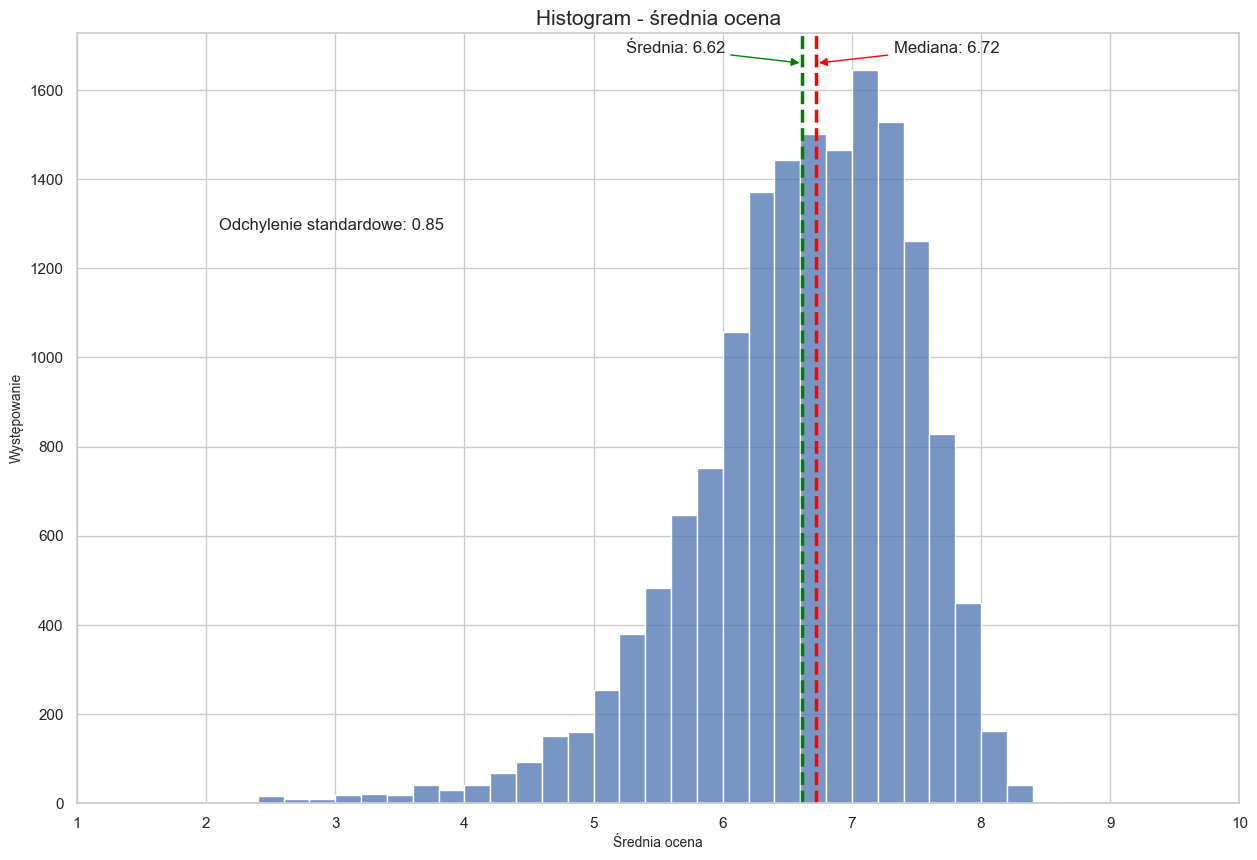

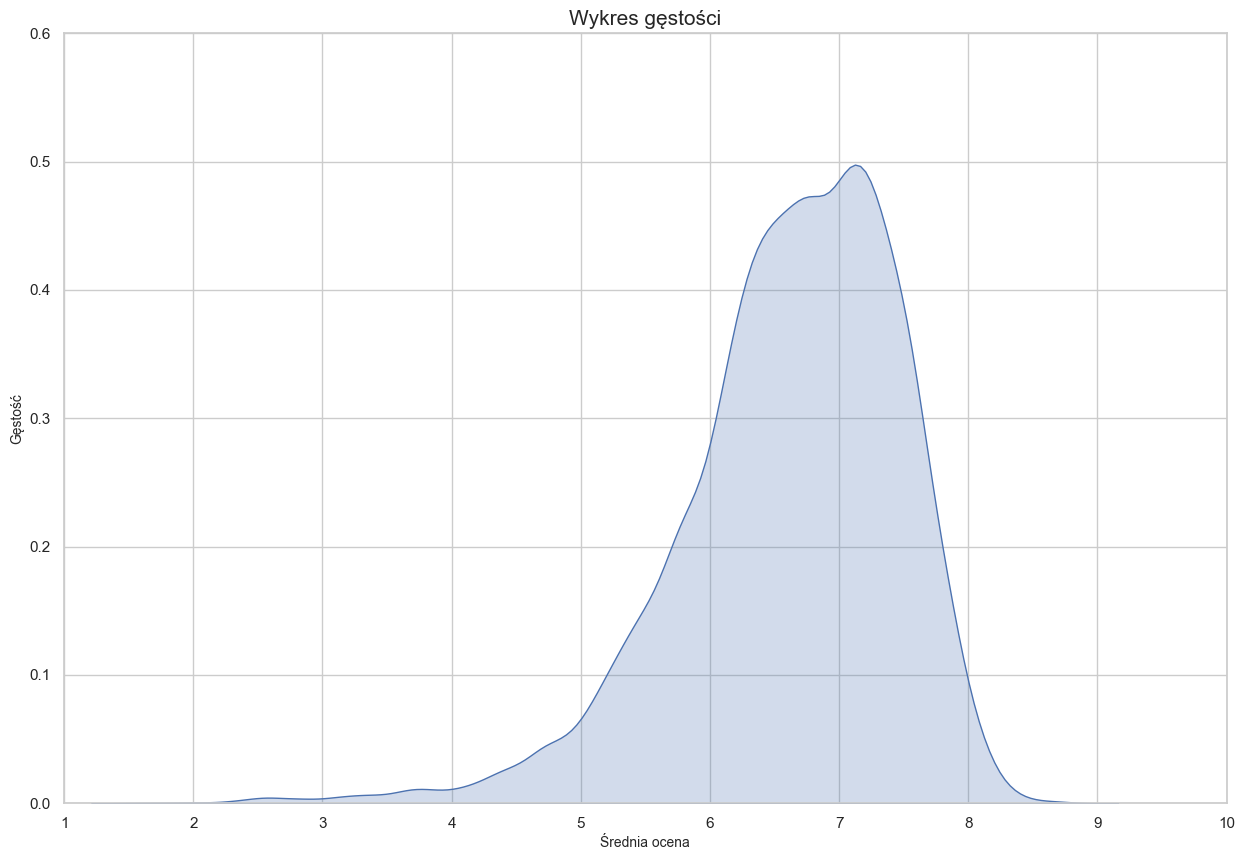

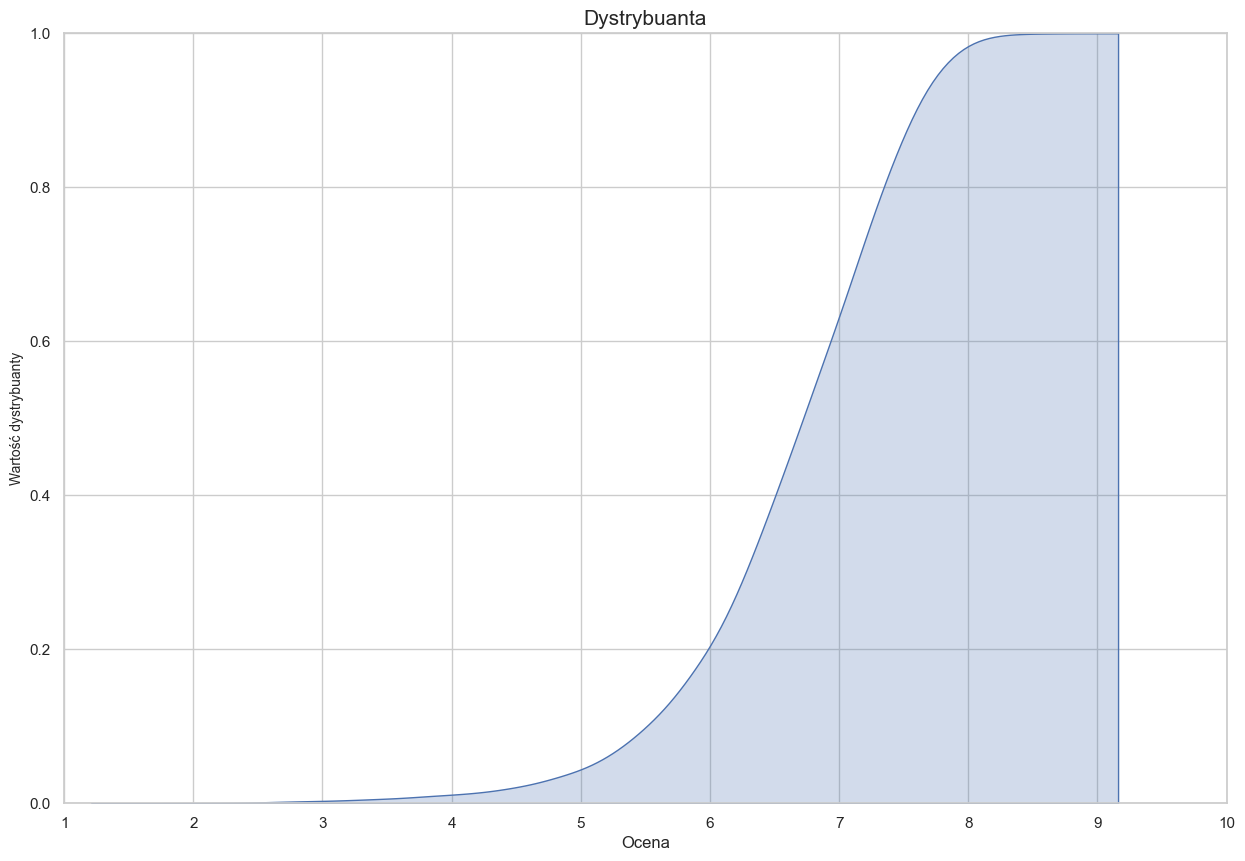

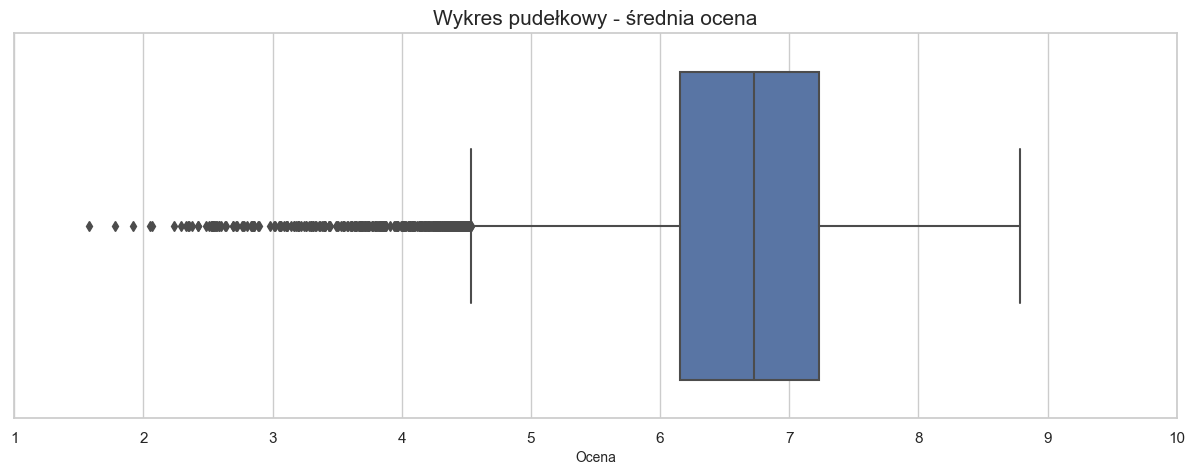

In [20]:
# podstawowe charakterystyki do dalszego użytku
rating_mean = df["Ocena"].mean()
rating_std = df["Ocena"].std()
rating_median = df["Ocena"].median()
rating_mode = df["Ocena"].mode()

# histogram
plt.subplots(figsize=(15,10))
hist = sns.histplot(data=df, x="Ocena", binwidth=0.2, binrange=(1,10), stat="count")
plt.title("Histogram - średnia ocena", fontsize=15)
plt.xlabel("Średnia ocena", fontsize=10)
plt.ylabel("Występowanie", fontsize=10)
hist.set_xlim(1,10)
plt.axvline(rating_mean, color="green", ls="--", lw=2.5)
plt.axvline(rating_median, color="red", ls="--", lw=2.5)
plt.annotate("Średnia: {:0.2f}".format(rating_mean), xy=(rating_mean, 1660), xytext=(rating_mean-0.6,1710), va="top", ha="right", arrowprops=dict(arrowstyle="-|>", color="green"))
plt.annotate("Mediana: {:0.2f}".format(rating_median), xy=(rating_median, 1660), xytext=(rating_median+0.6,1710), verticalalignment="top", arrowprops=dict(arrowstyle="-|>", color="red"))
plt.text(2.1,1285,"Odchylenie standardowe: "+str(round(rating_std,2)))
plt.show()

# rozkłąd gęstości
plt.figure(figsize=(15,10))
dnt = sns.kdeplot(df["Ocena"], fill = True)
plt.title("Wykres gęstości", fontsize=15)
plt.xlabel("Średnia ocena", fontsize=10)
plt.ylabel("Gęstość", fontsize=10)
dnt.set_xlim(1,10)
dnt.set_ylim(0,0.6)
plt.show()

# wykres dystrybuanty
plt.figure(figsize=(15,10))
dist = sns.kdeplot(df["Ocena"], fill=True, cumulative=True)
plt.title("Dystrybuanta", fontsize=15)
plt.ylabel("Wartość dystrybuanty", fontsize=10)
dist.set_xlim(1,10)
dist.set_ylim(0,1)
plt.show()

# wykres pudełkowy
plt.figure(figsize=(15,5))
box = sns.boxplot(x=df["Ocena"])
plt.title("Wykres pudełkowy - średnia ocena", fontsize=15)
plt.xlabel("Ocena", fontsize=10)
box.set_xlim(1,10)
plt.show()

Na podstawie powyższych wykresów można wyciągnąć następujące wnioski:
* średnia (6.62) jest mniejsza niż mediana (6.72), rozkład jest lewoskośny, posiada długi lewy ogon,
* odchylenie standardowe wynosi 0.83, jest to dość niska wartość, IQR na wykresie pudełkowym jest małe
* na podstawie wykresu dystrybuanty widać, że 20% filmów dostało średnią ocenę mniejszą od 6, natomiast prawie 80% mieści się w przedziale 6-8

Na bazie powyższych wniosków można domniemywać, że średnia ocena filmu nie ma rozkładu normalnego. Jest dużo "wartości odstających", które na wykresie pudełkowym są oddalone od rozstępu międzykwartylowego o ponad 1,5 IQR. 


## 3.1.1 Sprawdzenie skośności i kurtozy

**Skośność** to miara statystyczna opisująca kształt rozkładu.

Wylicza się ją z poniższego wzoru:

${\displaystyle g_{1}={\frac {m_{3}}{m_{2}^{3/2}}}={\frac {{\tfrac {1}{n}}\sum _{i=1}^{n}(x_{i}-{\overline {x}})^{3}}{\left[{\tfrac {1}{n}}\sum _{i=1}^{n}(x_{i}-{\overline {x}})^{2}\right]^{3/2}}}}$

gdzie:
* ${\overline {x}}$ - średnia z próby
* n - liczebność próby

Jeśli współczynnik skośności ma wartość:
* 0 to rozkład symetryczny,
* ujemną oznacza to, że rozkład jest pochylony w lewo, lewy ogon jest dłuższy, masa rozkładu jest skoncentrowana po prawej stronie,
* dodatnią wskazuje, że rozkład jest pochylony w prawo, prawy ogon jest dłuższy, masa rozkładu jest skoncentrowana po lewej stronie.

In [21]:
print("Skośność:", skew(df["Ocena"], axis=0))

Skośność: -1.0258221088493935


Rozkład lewoskośny. Oznacza to, że rozkład nie ma symetrycznego kształtu wokół średniej, a ma długi ogon po lewej stronie.

**Kurtoza** jest miarą tego, czy analizowane dane mają duże albo małe ogony w stosunku do rozkładu normalnego. Kurtoza to czwarty centralny moment podzielony przez kwadrat wariancji. Jeśli stosuje się definicję Fishera, to od wyniku odejmuje się 3.0, co daje 0.0 dla rozkładu normalnego.

Wylicza się ja z poniższego wzoru:

${\displaystyle {{Kurt}}={\frac {{\frac {1}{n}}{\sum _{i=1}^{n}(x_{i}-\mu )^{4}}}{\sigma ^{4}}}-3,}$

gdzie:
* $ x_{i}$ – i-ta wartość cechy,
* $\mu$ – wartość oczekiwana w populacji,
* $\sigma$ – odchylenie standardowe w populacji,
* n – liczebność próby.

Jeśli współczynnik kurtozy ma wartość:
* 0 to ogony są podobne do ogonów rozkładu normalnego,
* ujemną oznacza to, że rozkład ma lekkie ogony lub brak wartości odstających w stosunku do rozkładu normalnego,
* dodatnią wskazuje, że rozkład ma ciężkie ogony lub dużo wartości odstających w stosunku do rozkładu normalnego.

In [22]:
print("Kurtoza:", kurtosis(df["Ocena"], axis=0))

Kurtoza: 2.008151535645683


Oznacza to, że ogony rozkładu średniej oceny filmów są grube, a biorąc pod uwagę skośność i wyżej pokazane wykresy mamy do czynienia z grubym ogonem lewym.

## 3.1.2 Testy statystyczne

Z powyższych punktów widać, że rozkład zmiennej ocena nie jest rozkładem normalnym. W przypadku, gdy przyjmujemy hipotezę, że rozkład może być normalny stosuje się testy Shapiro-Wilka oraz Kołmogorowa-Smirnowa.

Testu **Shapiro-Wilka** używa się do sprawdzenia, czy zmienna ma rozkład normalny. Testuje on hipotezę zerową o tym, że dane pochodzą z rozkładu normalnego. Hipotezą alternatywna jest to, że dane nie pochodzą z rozkładu normalnego. Stosuje się go dla niewielkich próbek <2000.
Jeśli wybrany poziom ufności alfa wynosi 0.05, a wartość p jest mniejsza niż 0.05, to hipoteza zerowa, że dane mają rozkład normalny, zostaje odrzucona. Jeśli wartość p jest większa niż 0.05, hipoteza zerowa nie jest odrzucana.

W naszym przypadku liczebność próby jest większa niż 2000, dlatego nie można z niego skorzystać.

Test **Kołmogorowa-Smirnowa** również sprawdza zgodność zmiennej z rozkładem normalnym. Nie przyjmuje żadnych założeń dotyczących rozkładu danych i jest testem nieparametrycznym. Można go również użyć do wykazania, że dane pasują do rozkładu innego niż normalny. Ze względu na to, że test Kołmogorowa-Smirnowa jest bardziej ogólny, wydaje się być mniej skuteczny. Jako granicę próbki przyjmuje się n > 100. Hipoteza zerowa mówi, że dane mają określony rozkład, a hipoteza alternatywna mówi, że dane nie pochodzą z tego samego rozkładu. Sprawdzam, czy dane pochodzą z rozkładu normalnego przypisując do parametru cfd wartość "norm". Zakładany poziom istotności alfa = 0.05. 

${\displaystyle K_{n}=sup_{x}|F_{n}(x)-F(x)|}$

gdzie:

* $F_{n}(x)$ - dystrybuanta empiryczna dla n-elementowej próby
* $F(x)$ - dystrybuanta teoretyczna, w tym przypadku dystrybuanta rozkładu normalnego

In [23]:
# sprawdzenie testu Kołmogorowa-Smirnowa
D, p = stats.kstest(df["Ocena"], cdf="norm", args=(rating_mean, rating_std))
print("Wyniki testu Kołmogorowa-Smirnowa:")
print("D =", D)
print("pvalue =", p)

Wyniki testu Kołmogorowa-Smirnowa:
D = 0.05126665390740426
pvalue = 6.558494999153355e-37


Ponieważ pvalue jest bardzo małe (<0.05), odrzucam hipotezę zerową i przyjmuję hipotezę alternatywną, czyli zmienna nie pochodzi z rozkładu normalnego. Jest to zgodne z obserwacjami z powyższych punktów.

## 3.1.3 Znalezienie rozkładu dla zmiennej ocena

Wartości ocen są ograniczone do zakresu 1-10, możemy więc sprawdzić, czy zmienna ocena ma rozkład Beta. W rzeczywistości nasza próba zawiera wyniki w przedziale 1.58 do 8.79, ale nie można wykluczyć, że w przyszłości nie pojawią się filmy z oceną wychodzącą poza ten zakres. Spróbuję znaleźć dopasowanie do rozkładu beta, które charakteryzuje się tym, że ma sztywno określone granice, poza którymi prawdopodobieństwo wynosi 0.

$ f ( x ; α , β ) = {\frac {\Gamma (\alpha +\beta )}{\Gamma (\alpha )\Gamma (\beta )}}\,x^{\alpha -1}(1-x)^{\beta -1}\\[6pt]$

gdzie:
* α, β - parametry kształtu
* $\Gamma (z)$  - funkcja gamma
* $x$ - jest realizacją - obserwowaną wartością, która faktycznie wystąpiła 

Parametry rozkładu beta: 
 alpha = 15.9157157667626 
 beta = 9.640826098209036 
 loc = 1 
 scale = 9


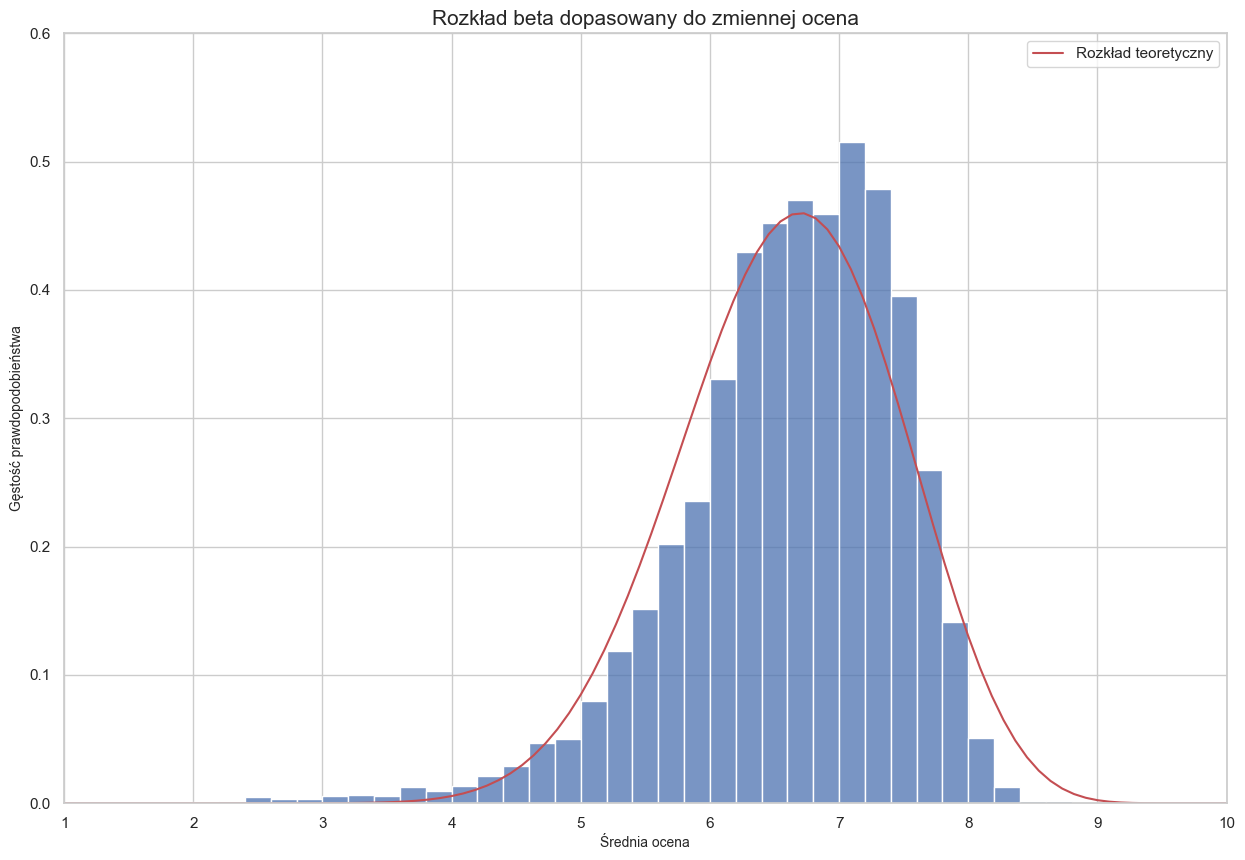

Wyniki testu Kołmogorowa-Smirnowa:
D = 0.04650709328010266
p-value = 1.8990776444131026e-30


In [24]:
# dopasowanie parametrów alpha oraz beta za pomocą funkcji fit, jako wartość parametru lokalizacji floc przyjmuję wartość 1, gdyż jest to najmniejsza wartość jaką może przyjąć ocena
alpha, beta, loc, scale = stats.beta.fit(df["Ocena"], floc=1, fscale=9)
print("Parametry rozkładu beta: \n alpha =", alpha,"\n beta =", beta,"\n loc =", loc, "\n scale =", scale)

# generowanie teoretycznego rozkładu beta o wyliczonych powyżej parametrach alpha, beta, loc, scale
x = np.linspace(1, 10, 100)
pdf = stats.beta.pdf(x, alpha, beta, loc, scale)

# sprawdzewnie testu Kołmogorowa-Smirnowa, zakładany poziom istotności alfa = 0.05
D, p = stats.kstest(df["Ocena"], "beta", args=(alpha, beta, loc, scale))

# wyświetlenie historgamu zmiennej ocena oraz teoretycznego rozkładu
plt.figure(figsize=(15,10))
sns.histplot(data=df, x="Ocena", binwidth=0.2, binrange=(1,10), stat="density")
plt.plot(x, pdf, "r", label="Rozkład teoretyczny")
plt.title("Rozkład beta dopasowany do zmiennej ocena", fontsize=15)
plt.xlim(1,10)
plt.ylim(0,0.6)
plt.xlabel("Średnia ocena", fontsize=10)
plt.ylabel("Gęstość prawdopodobieństwa", fontsize=10)
plt.legend()
plt.show()

# wyświetlenie wyników testu Kołmogorowa-Smirnowa
print("Wyniki testu Kołmogorowa-Smirnowa:")
print("D =", D)
print("p-value =", p)

Ponieważ p-value jest bardzo małe (<0.05), odrzucam hipotezę zerową i przyjmuję hipotezę alternatywną, czyli zmienna nie pochodzi z rozkładu beta.

Następnie korzystam z funkcji **fitter**, która pozwala nam na automatyczne przeprowadzenie testów dopasowania do wszystkich dystrybucji, które są dostępne aktualnie w bibliotece *scipy*.  Gdy w poleceniu nie wybierzemy parametru *distributions* funkcja **fitter** obliczenia trwają dość długo ze względu na liczbę dystrybucji, więc po wstępnym uruchomieniu funkcji zostawiam jedynie zapis z dystrybucją, która dała najlepsze dopasowanie.

Fitting 1 distributions: 100%|██████████| 1/1 [00:29<00:00, 29.68s/it]


sumsquare_error         aic            bic    kl_div  \
genhyperbolic          0.01134  344.045136 -225992.716631  0.004526   

               ks_statistic  ks_pvalue  
genhyperbolic      0.012681   0.011677

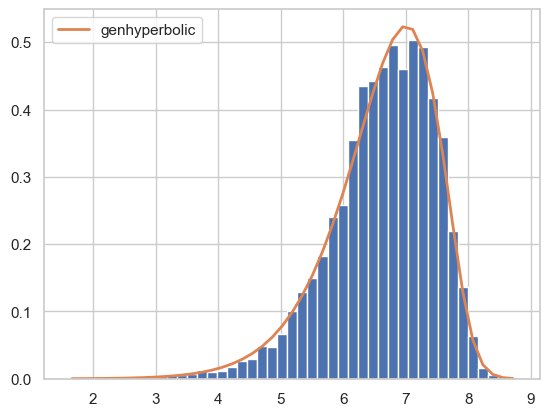

In [25]:
f = Fitter(df["Ocena"], bins=45, timeout=120, distributions="genhyperbolic")
f.fit()
f.summary()

Najlepsze dopasowanie uzyskano dla rozkładu generalised hyperbolic (uogólniony rozkład hiperboliczny). Jednak p-value wynosi jedynie 0.012, więc przy założeniu poziomu ufności 0.05 muszę odrzucić również hipotezę, że zmienna pochodzi z tego rozkładu.

## 3.2 Porównanie ocen użytkowyników i ocen krytyków

Chcę sprawdzić, jaka jest zależność pomiędzy oceną użytkowników serwisu a oceną krytyków. W tym celu przedstawię na jednym histogramie wartości z tych dwóch kolumn.
Przez to, że ocen krytyków jest zdecydowanie mniej, przyjmuję większą długość przedziału równą 1. Powodem takiego podziału jest również fakt, że na średnią ocenę krytyków składa się zdecydowanie mniej ocen niż na średnią ocenę użytkowników, stąd przyjmuje ona często wartości bardziej zbliżone do pełnych liczb. Ponieważ ocena krytyków nie pojawia się dla każdego z filmów, to na potrzebę tej analizy usuwam filmy, które nie otrzymały żadnej oceny krytyków.

In [26]:
df_critics = df.where(df["Liczba ocen krytyków"]>0).dropna(how="all")
df_critics[["Ocena", "Liczba ocen", "Ocena krytyków", "Liczba ocen krytyków"]].agg(["mean", "median"])

Ocena   Liczba ocen  Ocena krytyków  Liczba ocen krytyków
mean    6.747947  25161.280011        6.091094               5.77741
median  6.853800   3963.000000        6.250000               3.00000

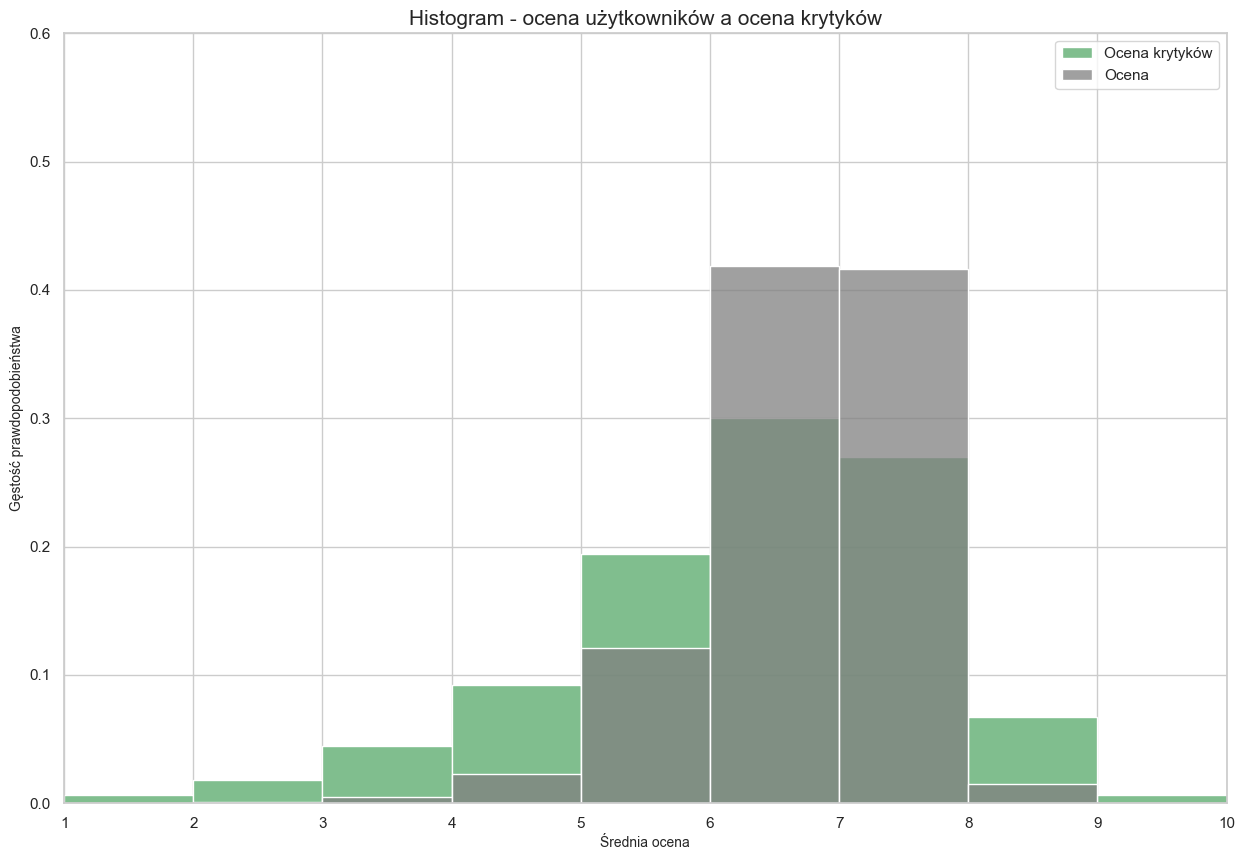

In [27]:
sns.set_palette("pastel")
plt.subplots(figsize=(15,10))
sns.histplot(data=df_critics, x="Ocena krytyków", binwidth=1, binrange=(1,10), stat="density", color="g", label="Ocena krytyków")
sns.histplot(data=df_critics, x="Ocena", binwidth=1, binrange=(1,10), stat="density", color="grey", label="Ocena")
plt.title("Histogram - ocena użytkowników a ocena krytyków", fontsize=15)
plt.xlabel("Średnia ocena", fontsize=10)
plt.ylabel("Gęstość prawdopodobieństwa", fontsize=10)
plt.xlim(1,10)
plt.ylim(0,0.6)
plt.legend()
plt.show()

Widać większe spłaszczenie wykresu średnich ocen krytyków. Są oni skłonni do oceniania filmów w sposób bardziej krytyczny. Średnia ocena krytyków wynosi 6.09, przy średniej ocenie użytkowników 6.74. Zdecydowanie częściej pojawiają się oceny poniżej 5. Należy jednak pamiętać, że średnia ocena krytyków może być liczona nawet z pojedynczej oceny krytyka, co znacznie zwiększa prawdopodobieństwo pojawienia się oceny ekstremalnej. Mediana dla liczby ocen krytyków wynosi jedynie 3 oceny krytyków, a aż 3963 dla użytkowników. Użytkownicy dużo częściej niż krytycy oceniają filmy w zakresie 6-8.

Sprawdzę na wykresie punktowym czy można zaobserwować zależność pomiędzy tymi dwoma ocenami.

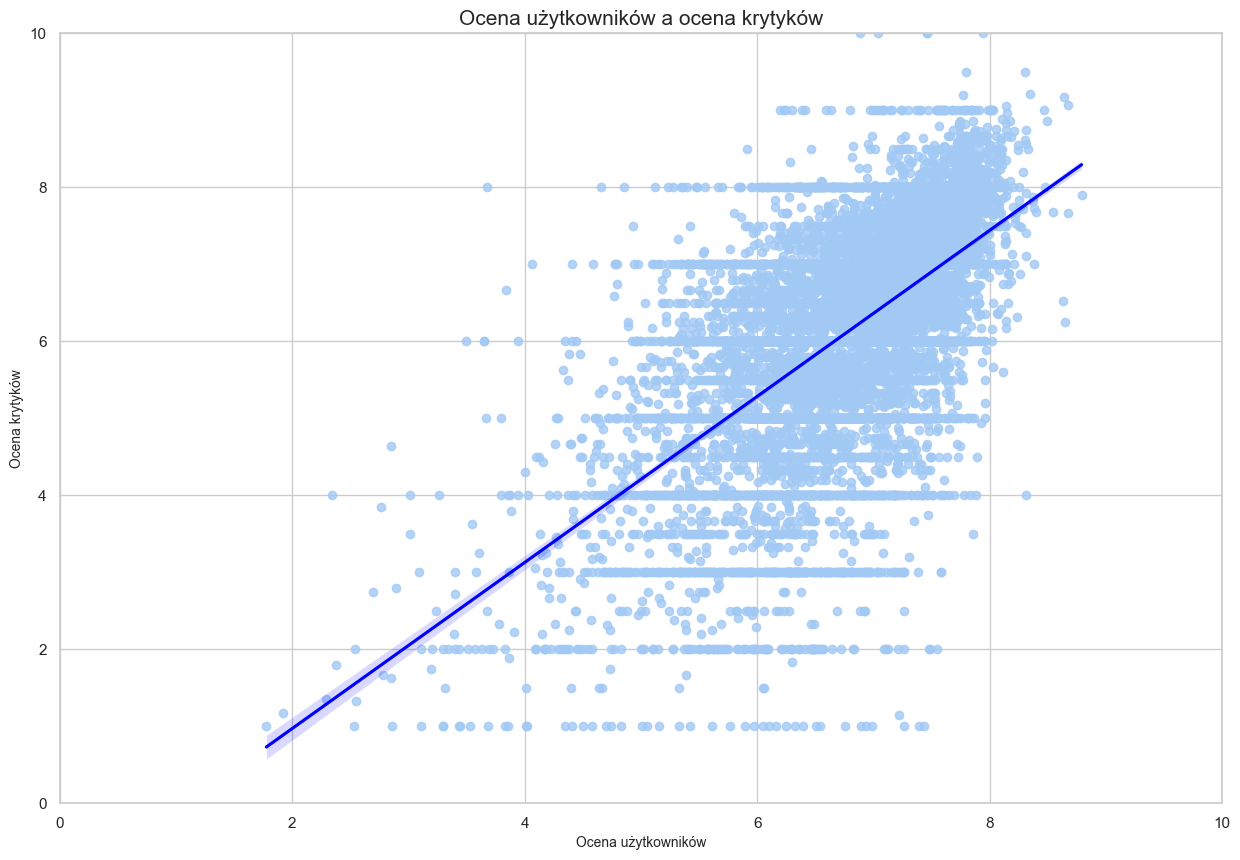

In [28]:
plt.figure(figsize=(15,10))
sns.regplot(df_critics, x="Ocena", y="Ocena krytyków", line_kws={"color": "blue"})
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Ocena użytkowników a ocena krytyków", fontsize=15)
plt.xlabel("Ocena użytkowników", fontsize=10)
plt.ylabel("Ocena krytyków", fontsize=10)
plt.show()

Widzimy, że istnieje duża koncentracja punktów, biegnąca po linii prostej, co oznacza, że w większości przypadków oceny filmów według użytkowników serwisu są zgodne z ocenami krytyków. Krytycy znacznie częściej niż widzowie są skłonni dać filmowi ocenę >= 8. W zakresie 5-7 użytkownicy dają średnio lepsze oceny niż krytycy. Widać, że dużo ocen krytyków przyjmuje wartości całkowite, co świadczy o niewielkiej liczbie ocen. W momencie gdy film ma tylko 1 ocenę krytyka, jest dużo większa szansa, że będzie ona znacznie odstawać od oceny użytkowników, czyli znajdzie się daleko od narysowanej linii regresji. Poniżej zbadam jak zmieni się wykres gdy weźmiemy pod uwagę filmy ocenione przez co najmniej 3 krytyków.

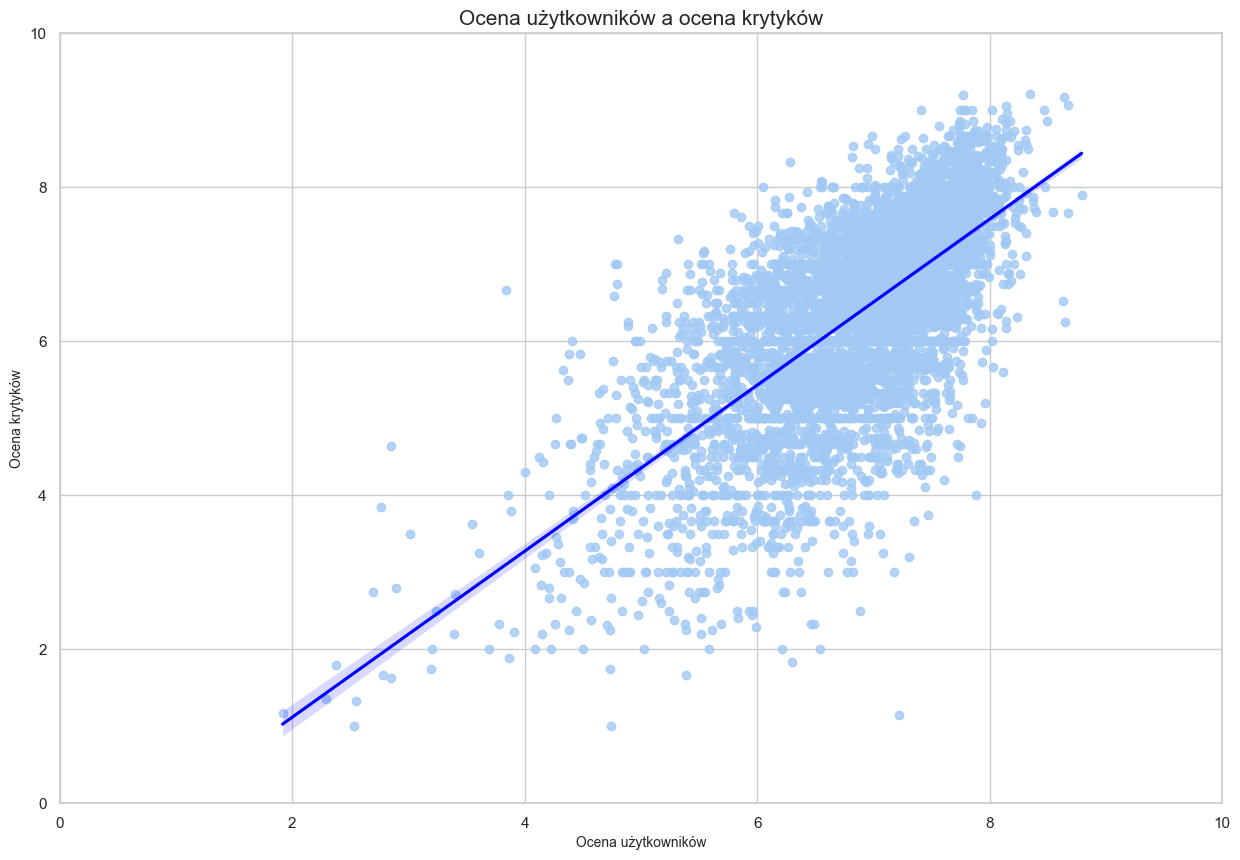

In [29]:
plt.figure(figsize=(15,10))
sns.regplot(df_critics.where(df_critics["Liczba ocen krytyków"]>2), x="Ocena", y="Ocena krytyków", line_kws={"color": "blue"})
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Ocena użytkowników a ocena krytyków", fontsize=15)
plt.xlabel("Ocena użytkowników", fontsize=10)
plt.ylabel("Ocena krytyków", fontsize=10)
plt.show()

Charakter wykresu nie uległ znaczącej zmianie, ale liczba wartości odstających jest zmniejszona.

## 3.3 Rozkład pojedynczych ocen

Podczas scrapingu uzyskałam, poza średnią oceną, również informacje o dokładnym wystąpieniu wszystkich poszczególnych ocen użytkowników. Analiza tych ocen da dodatkowe informacje, na temat jak użytkownicy stosują używaną w serwisie skalę ocen 1-10.

In [30]:
df_rating_single = df[[col for col in df.columns if col.isdigit()]]
sum_rating_single = pd.DataFrame({"Ocena": range(1,11), "Suma": df_rating_single.sum()})
sum_rating_single["Procent"] = sum_rating_single["Suma"] / sum(sum_rating_single["Suma"]) * 100
sum_rating_single

Ocena      Suma    Procent
1       1   2425617   0.867833
2       2   2050912   0.733772
3       3   5587049   1.998925
4       4   8763648   3.135444
5       5  20390078   7.295129
6       6  41276790  14.767942
7       7  72725471  26.019599
8       8  72256203  25.851705
9       9  33445433  11.966052
10     10  20581455   7.363599

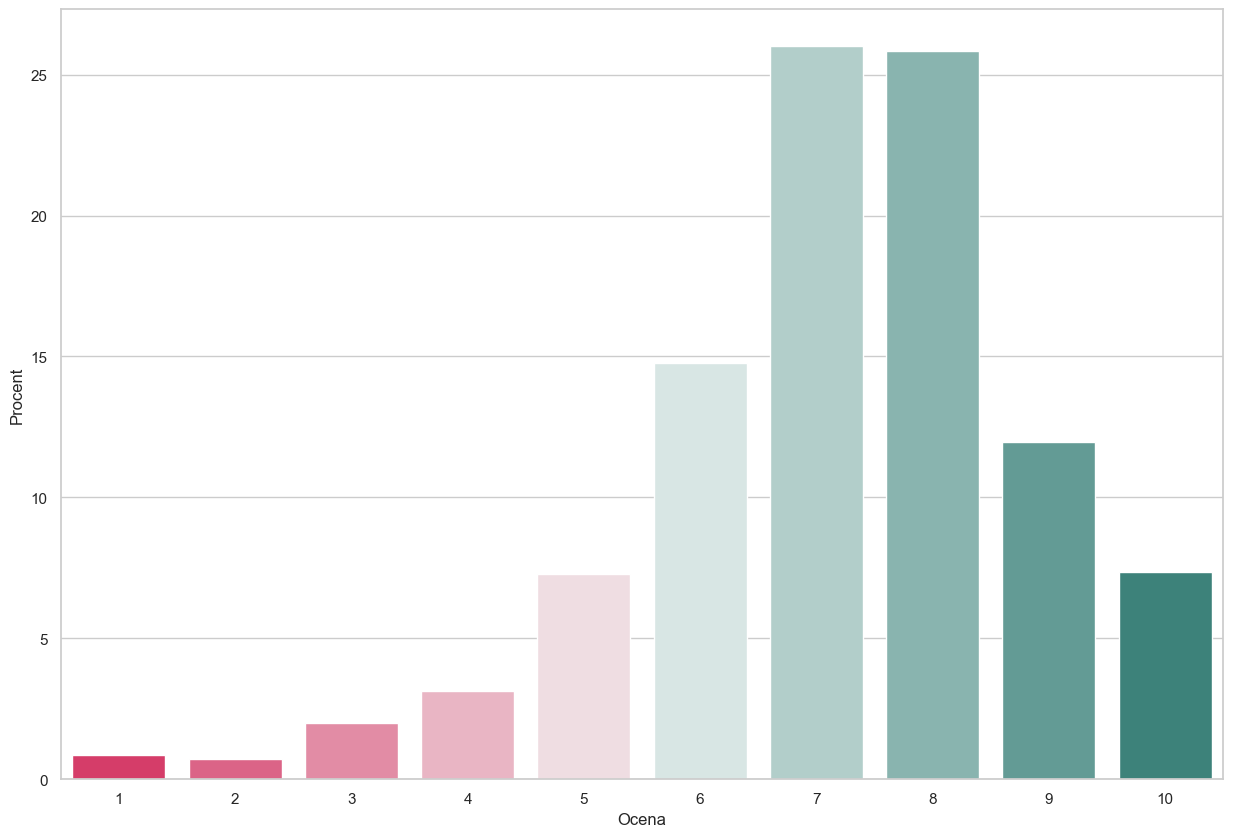

In [31]:
plt.figure(figsize=(15,10))
palette = sns.diverging_palette(0, 180, n=10)
sns.barplot(x="Ocena", y="Procent", data=sum_rating_single, palette=palette, saturation=1, estimator=np.mean)
plt.show()

Powyższy wykres wykazuje, że ponad 50% ocen stanowią same 7 i 8. Dalej w kolejności popularności występują 6, 8, 10 i 5. Występowanie pozostałych ocen 1-4 jest sumarycznie na poziomie 6,7%, czyli mniej niż samych 5. Co ciekawe użytkownicy chętniej używają oceny 1 niż 2. Analiza tych danych stawia pod znakiem zapytania użyteczność tak szerokiej skali ocen. Wykres ten jest jednocześnie wytłumaczeniem, skąd na wykresie średniej oceny filmów występuje tak duże zagęszczenie wokół średniej.

## 3.4 Analiza zmiennej długość

Filmy mogą mieć różne długości, przy czym tradycyjnie dzieli się je na pełnometrażowe, średniometrażowe i krótkometrażowe. Podział ten jest subiektywny i większość akademii filmowych definiuje je na swój sposób, zazwyczaj w celu zakwalifikowania filmu do odpowiedniej kategorii przy wręczaniu nagród. Zbadam, jak wygląda rozkład długości filmów w bazie danych, aby sprawdzić, czy można wydzielić w nim te 3 grupy.

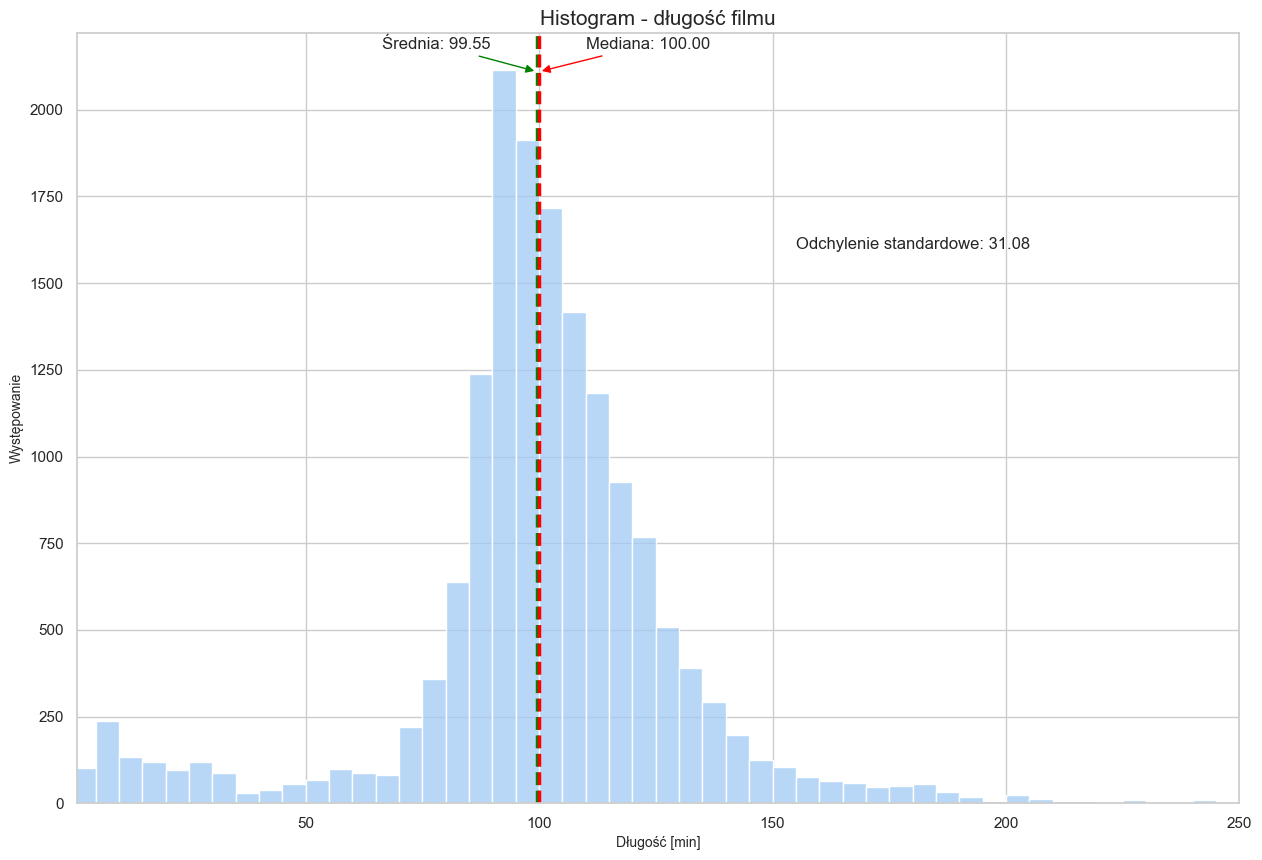

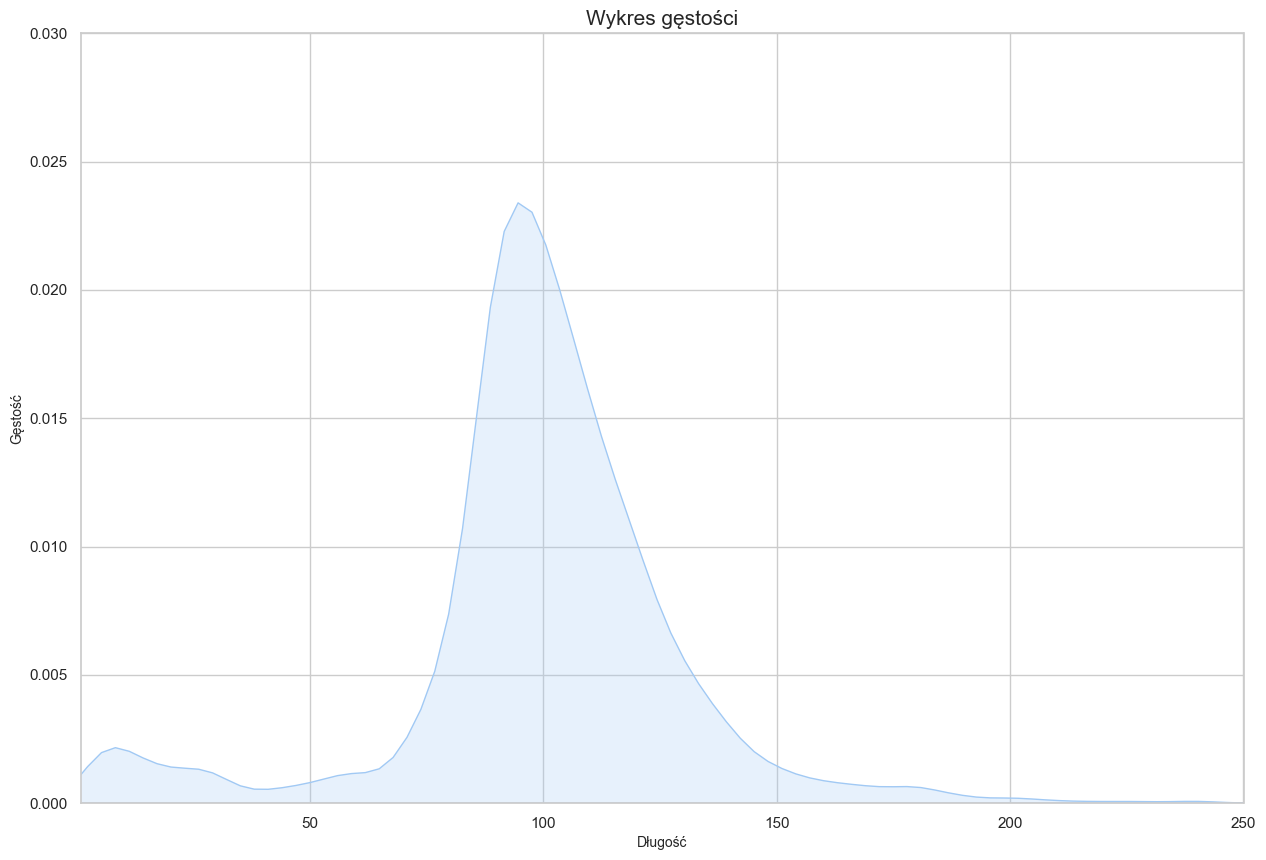

In [32]:
# podstawowe charakterystyki do dalszego użytku
length_mean = df["Długość"].mean()
length_std = df["Długość"].std()
length_median = df["Długość"].median()

# histogram
plt.subplots(figsize=(15,10))
hist=sns.histplot(data=df, x="Długość", binwidth=5, binrange=(0,250), stat="count")
plt.title("Histogram - długość filmu", fontsize=15)
plt.xlabel("Długość [min]", fontsize=10)
plt.ylabel("Występowanie", fontsize=10)
hist.set_xlim(1,250)
plt.axvline(length_mean, color="green", ls="--", lw=2.5)
plt.axvline(length_median, color="red", ls="--", lw=2.5)
plt.annotate("Średnia: {:0.2f}".format(length_mean), xy=(length_mean, 2110), xytext=(length_mean-10,2210), va="top", ha="right", arrowprops=dict(arrowstyle="-|>", color="green"))
plt.annotate("Mediana: {:0.2f}".format(length_median), xy=(length_median, 2110), xytext=(length_median+10,2210), verticalalignment="top", arrowprops=dict(arrowstyle="-|>", color="red"))
plt.text(155,1600,"Odchylenie standardowe: "+str(round(length_std,2)))
plt.show()

# rozkład gęstości
plt.figure(figsize=(15,10))
dnt=sns.kdeplot(df["Długość"], fill = True)
plt.title("Wykres gęstości", fontsize=15)
plt.xlabel("Długość", fontsize=10)
plt.ylabel("Gęstość", fontsize=10)
dnt.set_xlim(1,250)
dnt.set_ylim(0,0.03)
plt.show()

Można zaobserwować wielomodalność na powyższym wykresie, wprowadzam zatem podział na kategorie według poniżej zdefiniowanej funkcji.

In [33]:
def długość_kategoria(x):
    if x <= 35:
        return "Krótkometrażowy"
    elif x <= 80:
        return "Średniometrażowy"
    else:
        return "Długometrażowy"

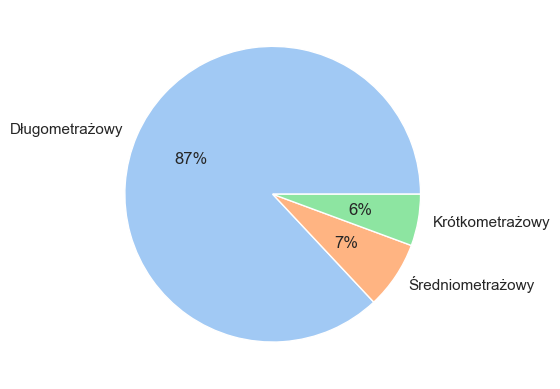

In [34]:
df["Typ długości"] = df["Długość"].apply(długość_kategoria)
df_length = df["Typ długości"].value_counts().reset_index()
df_length.columns = ["Długość", "Liczba"]
colors = sns.color_palette("pastel")
plt.pie(df_length["Liczba"], labels=df_length["Długość"], colors=colors, autopct="%.0f%%")
plt.show()

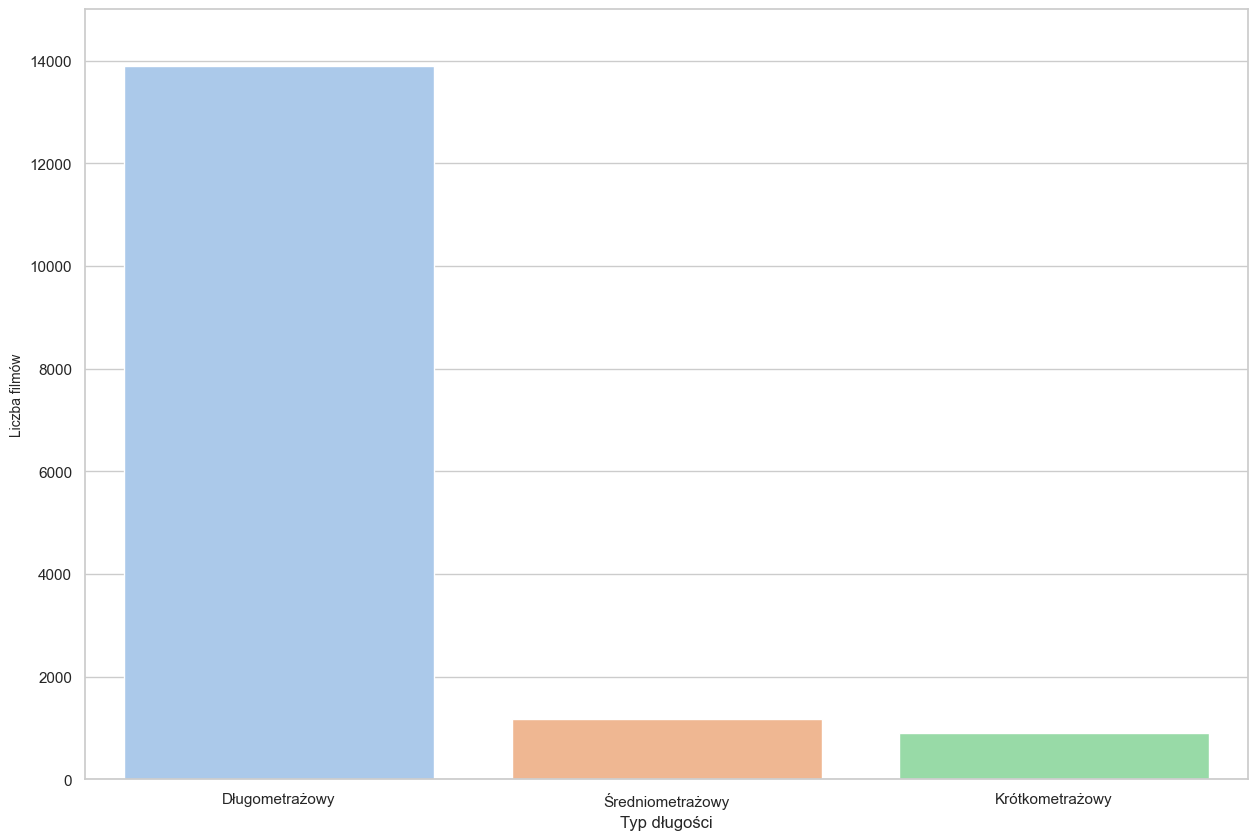

In [35]:
plt.figure(figsize=(15,10))
sns.countplot(x=df["Typ długości"])
plt.ylim(0,15000)
plt.ylabel("Liczba filmów", fontsize=10)
plt.show()

## 3.6 Analiza zmiennej rok

W tym punkcie zbadam jak zmieniała się liczba głosów oraz średnia ocena filmu na przestrzeni lat.

In [36]:
year_filmcount = df["Rok"].value_counts().sort_index().reset_index()
year_filmcount.columns = ["Rok", "Liczba wyprodukowanych filmów"]
fig = px.line(year_filmcount, x="Rok", y="Liczba wyprodukowanych filmów", title="Liczba wprodukowanych filmów według roku", width=1400, height=500)
fig.update_layout(margin=dict(l=20, r=20, t=40, b=20))
fig.show()
fig.write_html("rok.html")

Powyższy wykres dostarcza kilku ciekawych informacji:
* Można zaobserwować, że nastąpił stały wzrost liczby filmów po 1930 roku aż do 2008 roku, a w ostatnim stuleciu liczba produkowanych rocznie filmów znacznie wzrosła od 1980 roku.
* W tym zbiorze danych rok 2008 był rokiem, w którym wyprodukowano największą liczbę filmów – łącznie 625.
* Lata między 1980 a 2010 przyniosły największy wzrost liczby wyprodukowanych filmów rok do roku.
* W 2012 roku nastąpił gwałtowny spadek liczby wyprodukowanych filmów. W 2011 roku było ich 624, a z każdym kolejnym rokiem liczba wyprodukowanych filmów spada.
* Liczba filmów od 2020 roku gwałtownie spada. Może to być spowodowane tym, że nowe filmy mają mniejszą szansę na zebranie minimum 500 głosów, co było jednym z kryteriów podczas zbierania danych. Na obniżenie ilości produkowanych filmów może mieć również wpływ pandemia.

In [37]:
year_mean_rating = df.pivot_table("Ocena", index="Rok", aggfunc="mean").reset_index()
fig = px.line(year_mean_rating, x="Rok", y="Ocena", title="Średnia ocena filmów według roku", width=1400, height=500)
fig.update_layout(margin=dict(l=20, r=20, t=40, b=20))
fig.show()
fig.write_html("ocena.html")

Wartości średniej oceny w latach 1888-1920 cechują się dużą zmiennością. Jest to spowodowane tym, że w pierwszych latach istnienia kinematografii liczba produkowanych filmów była niewielka, stąd często są to pojedyncze wartości średniej oceny dla roku. Na początku były też lata, w których nie powstał żaden film, np. pomiędzy rokiem 1888 a 1895 nie ma w zbiorze danych żadnego filmu. Od roku 1940 średnia ocena filmu ma tendencję spadkową. Można wysnuć hipotezę, że ludzie stali się w ostatnich latach bardziej krytyczni w stosunku do nowych produkcji.

## 3.7 Budżet a box office

W tym punkcie przeanalizuję, jak budżet filmów wpływa na jego ocenę oraz na box office. Na początek zbadam, jaki jest rozkład budżetów filmów w bazie danych.

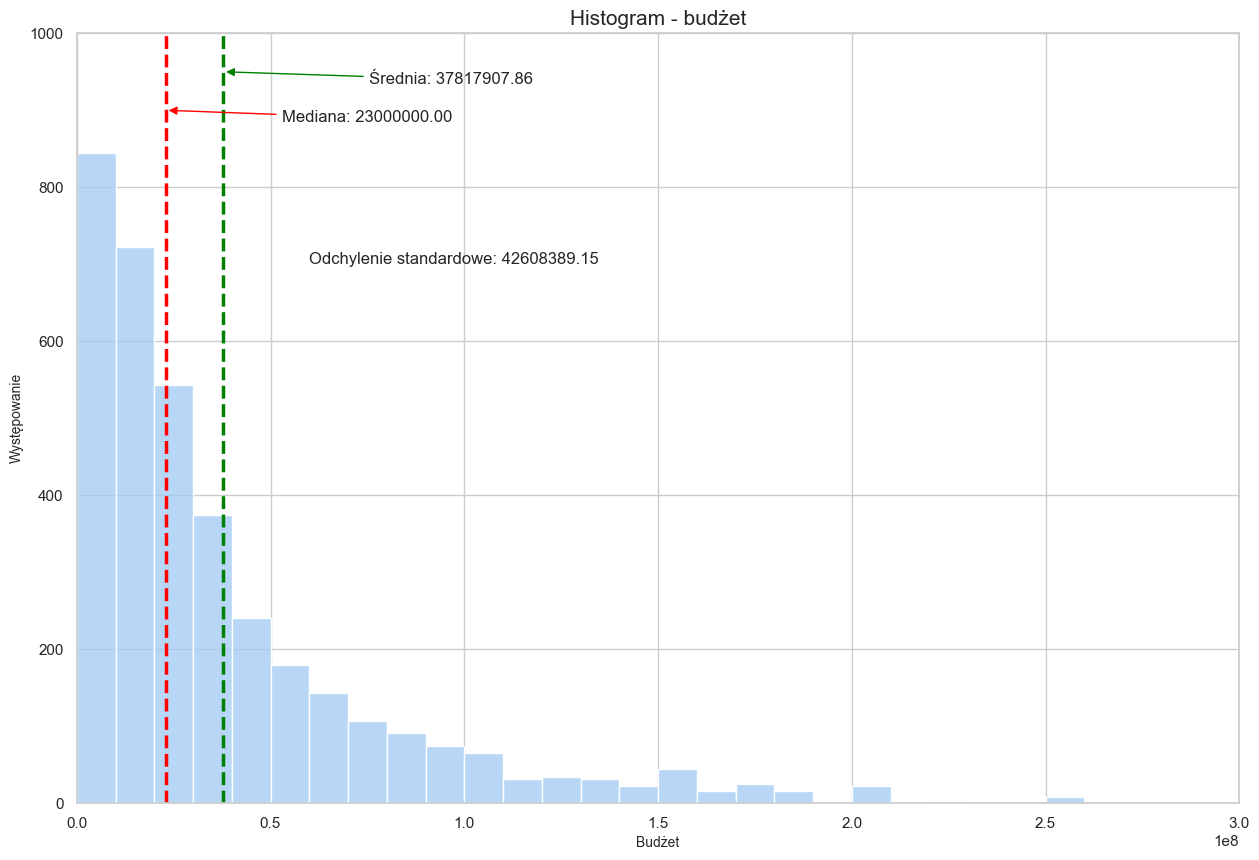

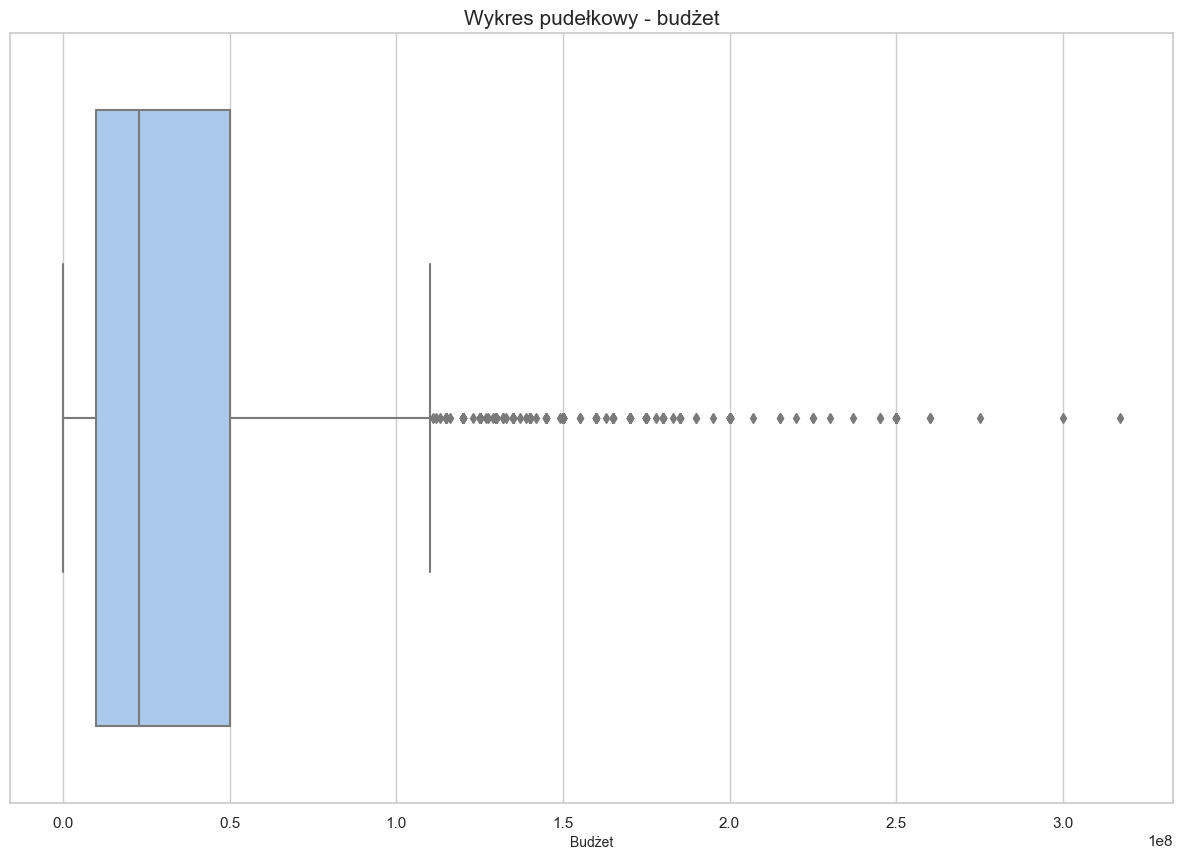

In [38]:
# podstawowe charakterystyki do dalszego użytku
budget_mean=df["Budżet"].mean()
budget_std=df["Budżet"].std()
budget_median=df["Budżet"].median()

# histogram
plt.subplots(figsize=(15,10))
hist=sns.histplot(data=df, x="Budżet", binwidth=10000000, binrange=(0,300000000), stat="count")
plt.title("Histogram - budżet", fontsize=15)
plt.xlabel("Budżet", fontsize=10)
plt.ylabel("Występowanie", fontsize=10)
hist.set_xlim(0,300000000)
hist.set_ylim(0,1000)
plt.axvline(budget_mean, color="green", ls="--", lw=2.5)
plt.axvline(budget_median, color="red", ls="--", lw=2.5)
plt.annotate("Średnia: {:0.2f}".format(budget_mean), xy=(budget_mean, 950), xytext=(budget_mean+80000000,950), va="top", ha="right", arrowprops=dict(arrowstyle="-|>", color="green"))
plt.annotate("Mediana: {:0.2f}".format(budget_median), xy=(budget_median, 900), xytext=(budget_median+30000000,900), verticalalignment="top", arrowprops=dict(arrowstyle="-|>", color="red"))
plt.text(60000000,700,"Odchylenie standardowe: "+str(round(budget_std,2)))
plt.show()

# wykres pudełkowy
plt.figure(figsize=(15,10))
box=sns.boxplot(x=df["Budżet"])
plt.title("Wykres pudełkowy - budżet", fontsize=15)
plt.xlabel("Budżet", fontsize=10)
plt.show()

Dużo filmów ma niewielkie budżety, natomiast niewiele jest filmów których budżety opiewają na bardzo dużą kwotę. Używam funkcji **fitter**, aby sprawdzić który rozkład teoretyczny najbardziej pasuje do rozkładu zmiennej budżet.

In [73]:
f = Fitter(df["Budżet"].dropna(), bins=25, timeout=30)
f.fit()
f.summary()

Fitting 110 distributions:  23%|██▎       | 25/110 [00:11<02:28,  1.74s/it]c:\Users\annak\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:3485: IntegrationWarning:

The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.

c:\Users\annak\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:3485: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

Fitting 110 distributions:  51%|█████     | 56/110 [00:44<02:33,  2.85s/it]SKIPPED johnsonsb distribution (taking more than 30 seconds)
SKIPPED johnsonsu distribution (taking more than 30 seconds)
Fitting 110 distributions:  55%|█████▍    | 60/110 [00:44<00:52,  1.05s/it]SKIPPED ksone distribution (taking more than 30 seconds)
SKIPPED levy distributi

sumsquare_error          aic            bic  kl_div  ks_statistic  \
wald          6.127988e-18  1072.417206 -174683.205438     inf      0.035416   
gilbrat       9.700433e-18  1065.038237 -173005.827141     inf      0.033203   
gibrat        9.700433e-18  1065.038237 -173005.827141     inf      0.033203   
genpareto     1.203380e-17  1070.833322 -172210.439703     inf      0.037758   
pareto        1.203409e-17  1070.861924 -172210.351276     inf      0.037784   

           ks_pvalue  
wald        0.000205  
gilbrat     0.000622  
gibrat      0.000622  
genpareto   0.000058  
pareto      0.000058

Najlepsze dopasowanie zaobserwowano dla rozkładu wald, gilbrat, gibrat, genpareto i pareto. P-value dla wszystkich z nich jest bardzo małe <0.0007, więc przy założeniu poziomu ufności 0.05 muszę odrzucić hipotezę, że zmienna pochodzi z któregokolwiek z tych rozkładów.

Sprawdzam następnie, które filmy przyniosły największy dochód oraz jaki wyglądał on na tle budżetu. Czy najbardziej dochodowe filmy na siebie zarobiły? Czy bardziej opłaca się robić film z dużym budżetem, bo przyniesie on większe zyski?

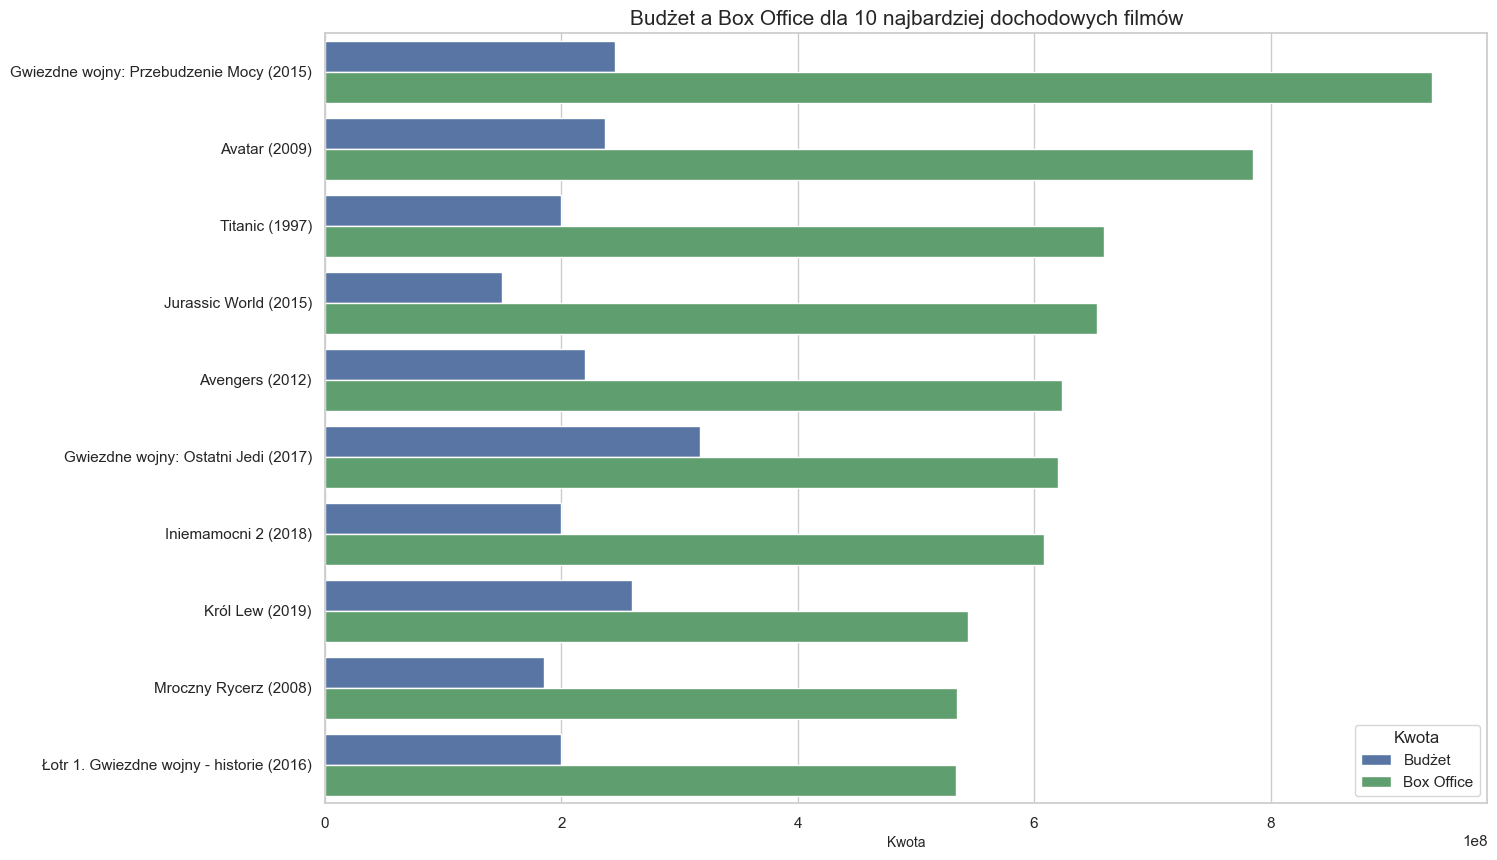

In [39]:
sns.set_theme(style="whitegrid")
# sortowanie po Box Office i wzięcie pierwszych 10 wartości
df_financial = df[(df["Budżet"].notna()) & (df["Box Office"].notna())].copy()
df_financial.sort_values(by="Box Office", ascending=False, inplace=True)

# funkcja melt żeby uzyskać poszerzoną tablicę
melted_df = pd.melt(df_financial.head(10)[["Tytuł","Budżet","Box Office","Rok"]],
                    id_vars=("Tytuł","Rok"), var_name="Kwota", value_name="Value")
melted_df["Tytuł (Rok)"] = melted_df["Tytuł"] + " (" + melted_df["Rok"].astype(str) + ")"

# wyświetlenie wykresu
plt.figure(figsize=(15,10))
sns.barplot(x="Value", y="Tytuł (Rok)", hue="Kwota", data=melted_df, palette=["b", "g"])

# dodanie etykiet
plt.title("Budżet a Box Office dla 10 najbardziej dochodowych filmów", fontsize=15)
plt.xlabel("Kwota", fontsize=10)
plt.ylabel("")
plt.show()

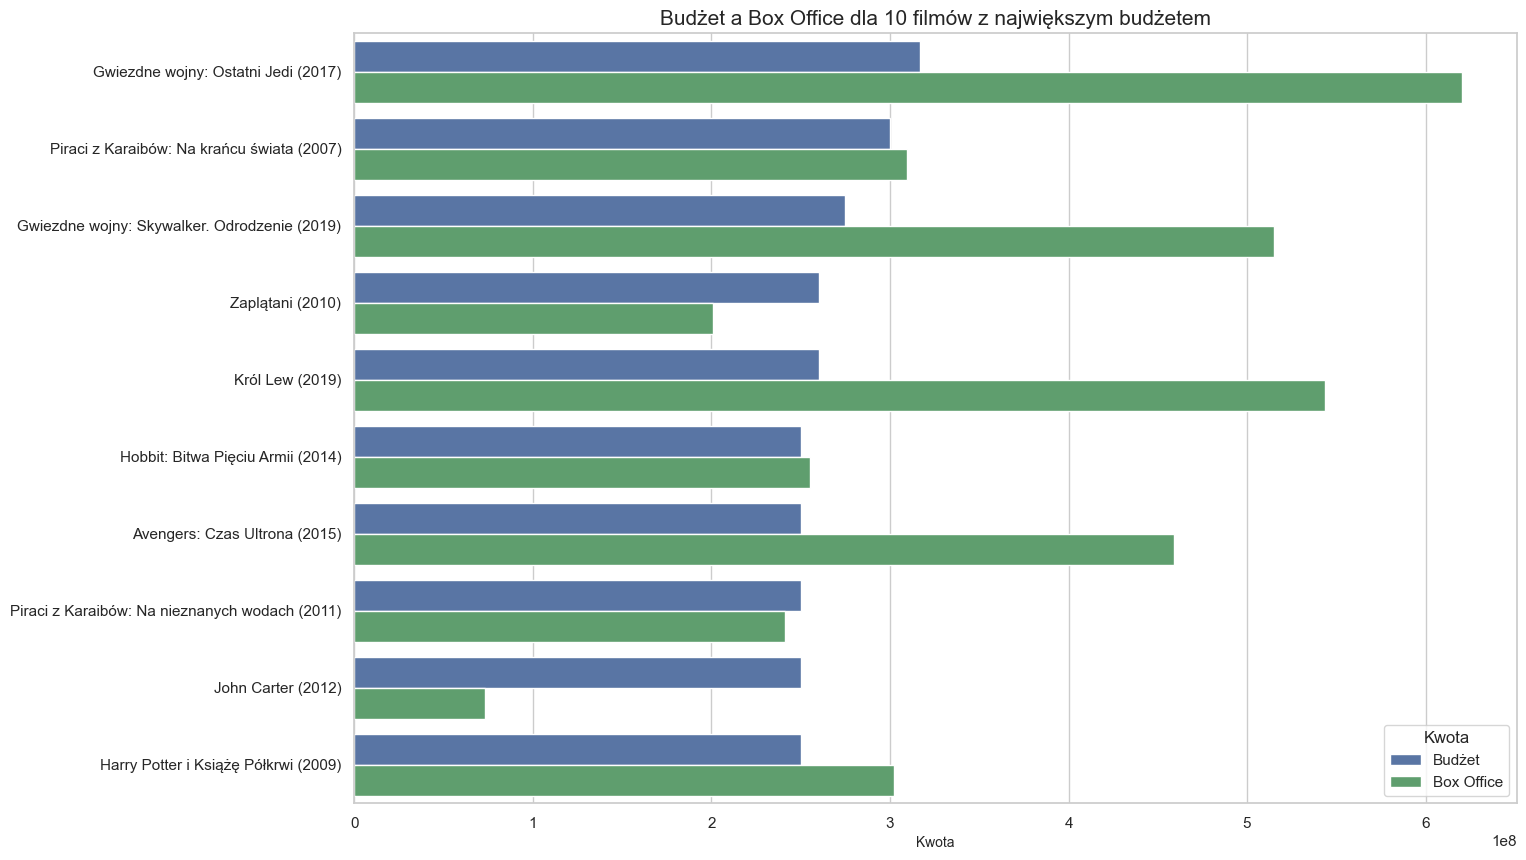

In [40]:
sns.set_theme(style="whitegrid")
# sortowanie po Box Office i wzięcie pierwszych 10 wartości
df_financial.sort_values(by="Budżet", ascending=False, inplace=True)

# funkcja melt żeby uzyskać poszerzoną tablicę
melted_df = pd.melt(df_financial.head(10)[["Tytuł","Budżet","Box Office","Rok"]],
                    id_vars=("Tytuł","Rok"), var_name="Kwota", value_name="Value")
melted_df["Tytuł (Rok)"] = melted_df["Tytuł"] + " (" + melted_df["Rok"].astype(str) + ")"

# wyświetlenie wykresu
plt.figure(figsize=(15,10))
sns.barplot(x="Value", y="Tytuł (Rok)", hue="Kwota", data=melted_df, palette=["b", "g"])

# dodanie etykiet
plt.title("Budżet a Box Office dla 10 filmów z największym budżetem", fontsize=15)
plt.xlabel("Kwota", fontsize=10)
plt.ylabel("")
plt.show()

Widać, że wszystkie filmy z największym box office w historii zarobiły kilkukrotnie więcej niż ich budżet. Jednak, że w przypadku najdroższych produkcji nie każda pozycja okazała się sukcesem. Niekoniecznie duży budżet przekłada się na większy zysk.
Sprawdzam dodatkowo wzajemną zależność tych zmiennych na wykresie punktowym.

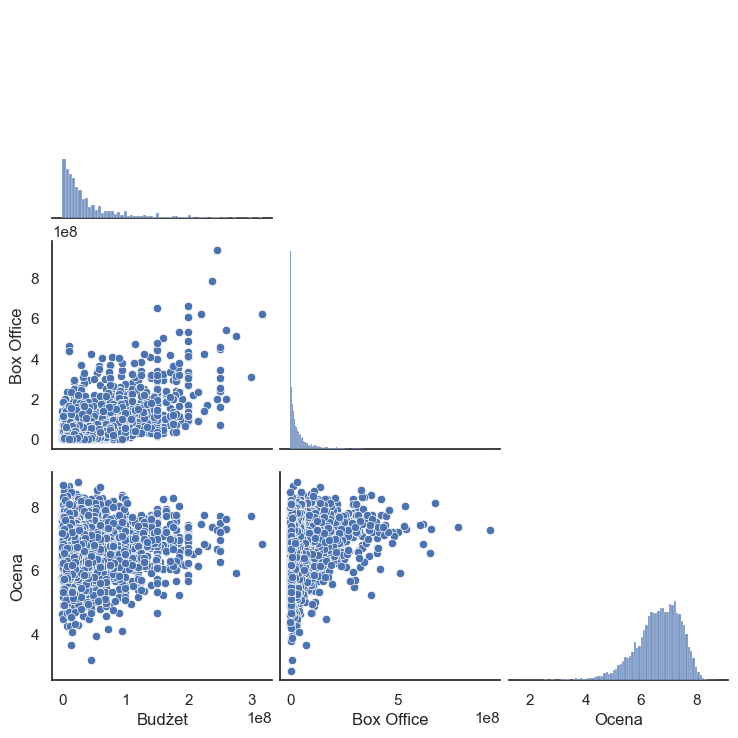

In [41]:
sns.set_style("white")
sns.pairplot(df[["Budżet", "Box Office", "Ocena"]], corner=True)
plt.show()

Widać ciekawą zależność oceny od budżetu. Przy zwiększaniu budżetu filmu jego średnia ocena zmierza do zakresu 6-8. Można wnioskować, że odpowiednio duży budżet przyniesie sukces filmowi, aczkolwiek rzadko filmy te są ocenione powyżej 8. 
Podobny rozkład jest na wykresie oceny od box office. Na tym wykresie wyraźnie widać, że filmy, które zostały dobrze ocenione przez publiczność, to filmy, które wygenerowały największy box office. Oceny publiczności są bardziej skoncentrowane między 5 a 8 dla filmów z największym box office.

Widać pewną korelację liniową między budżetem a box office, aczkolwiek jest bardzo dużo obserwacji odstających. Są filmy, które zarobiły wielokrotnie więcej nich ich budżet oraz takie, które nigdy się nie zwróciły. 

Poniżej wyświetlam 10 filmów, które mają najlepszy stosunek box office w USA do budżetu wprowadzając nową kolumnę do data frame o nazwie współczynnik.

In [42]:
df_financial["Współczynnik"] = df_financial["Box Office"] / df_financial["Budżet"]
df_financial[["Tytuł", "Gatunek", "Rok", "Współczynnik", "Budżet", "Box Office"]].sort_values(by="Współczynnik", ascending=False).head(10).round(1)

Tytuł          Gatunek   Rok  \
583                        Paranormal Activity           Horror  2007   
578                        Blair Witch Project           Horror  1999   
1117                           Głębokie gardło              XXX  1972   
884                         Głowica ścierająca  Surrealistyczny  1977   
1613       El mariachi, czyli kariera klezmera      Gangsterski  1992   
851                              Super Size Me     Dokumentalny  2004   
12700                    Amerykańskie graffiti           Dramat  1973   
980    Królewna Śnieżka i siedmiu krasnoludków         Animacja  1937   
1067                                     Rocky           Dramat  1976   
1268                       Clerks - Sprzedawcy   Komedia obycz.  1994   

       Współczynnik     Budżet   Box Office  
583          7194.6    15000.0  107918810.0  
578          2342.3    60000.0  140539099.0  
1117         1800.0    25000.0   45000000.0  
884           350.0    20000.0    7000000.0  
1613          291.6     7000.0    2040920.0  
851           177.5    65000.0   11536423.0  
12700         148.0   777000.0  115000000.0  
980           123.4  1499000.0  184925486.0  
1067          122.1   960000.0  117235147.0  
1268          116.7    27000.0    3151130.0

Wielokrotnie większy zysk niż budżet filmów przyniosły produkcje z niewielkim budżetem.

## 3.8 Komenatrze

Zbadam czy ocena filmu ma wpływ na liczbę komentarzy na jego temat w serwisie.

In [43]:
df["Komentarze"].describe()

count     15966.000000
mean        346.395591
std        2044.487420
min           0.000000
25%          22.000000
50%          52.000000
75%         170.000000
max      113883.000000
Name: Komentarze, dtype: float64

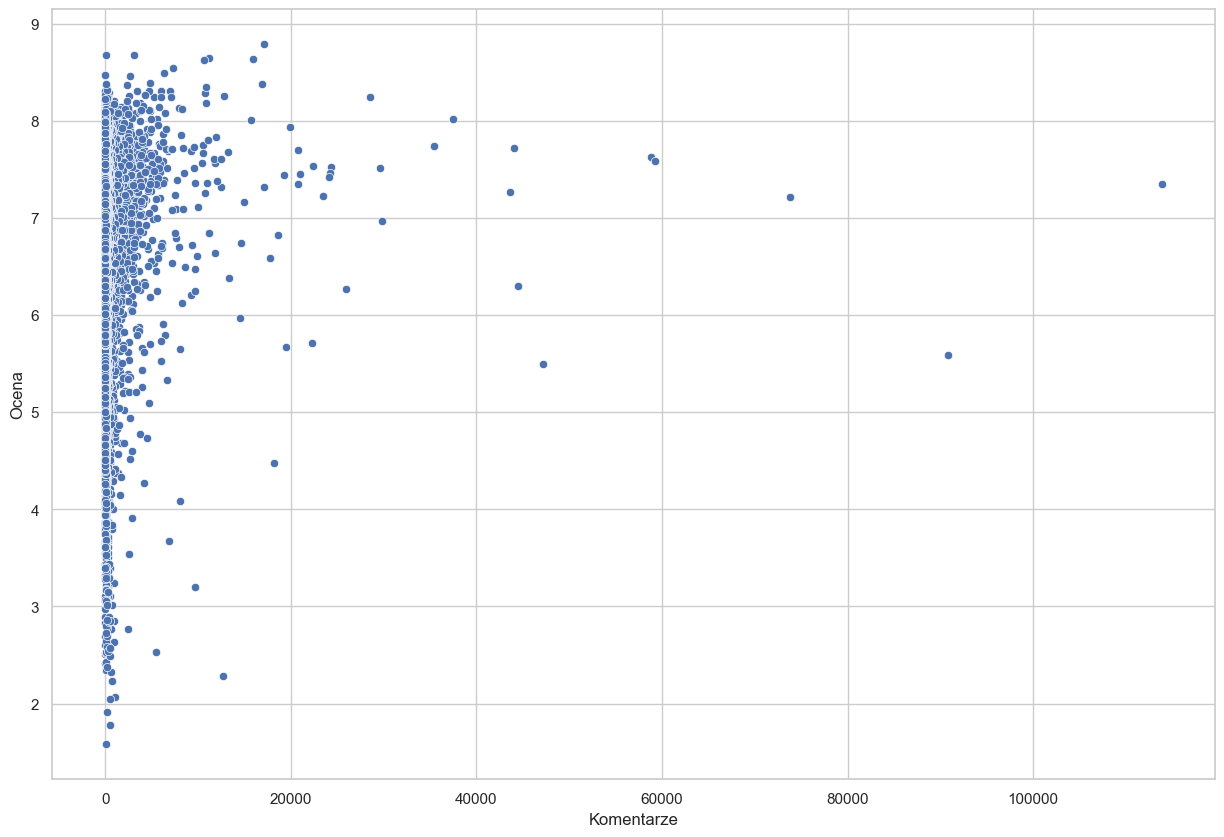

In [44]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10))
sns.scatterplot(df, x=df["Komentarze"], y=df["Ocena"])
plt.show()

In [45]:
comments = df.sort_values(by="Komentarze", ascending=False, inplace=False)
comments[["Tytuł", "Gatunek", "Rok", "Ocena", "Budżet", "Box Office", "Komentarze"]].head(10)

Tytuł     Gatunek   Rok    Ocena  \
11                              Avatar      Sci-Fi  2009  7.35572   
19                            Zmierzch      Horror  2008  5.58438   
333         Hobbit: Bitwa Pięciu Armii     Fantasy  2014  7.21986   
158           Hobbit: Pustkowie Smauga     Fantasy  2013  7.58894   
35            Hobbit: Niezwykła podróż     Fantasy  2012  7.62446   
151   Saga "Zmierzch": Księżyc w nowiu      Horror  2009  5.50119   
209                         Prometeusz      Horror  2012  6.29594   
143            Mroczny Rycerz powstaje       Akcja  2012  7.72588   
400  Gwiezdne wojny: Przebudzenie Mocy  Przygodowy  2015  7.26770   
14                      Mroczny Rycerz       Akcja  2008  8.02298   

          Budżet   Box Office  Komentarze  
11   237000000.0  785221649.0      113883  
19    37000000.0  192769854.0       90795  
333  250000000.0  255138261.0       73762  
158          NaN  258387334.0       59245  
35   180000000.0  303030651.0       58775  
151   50000000.0  297816253.0       47123  
209  130000000.0  126477084.0       44498  
143  250000000.0  448149584.0       44055  
400  245000000.0  936662225.0       43605  
14   185000000.0  534987076.0       37425

Występują filmy, które szczególnie mocno rozgrzewają klawiatury użytkowników serwisu. Najczęściej komentowanym filmem jest "Avatar", następnie seria "Zmierzch", "Hobbit" i "Batman". 75% filmów zebrało liczbę komentarzy < 170. Nie zaobserwowałam żadnej korelacji między oceną a liczbą komentarzy.

# 4\. Analiza zmiennych kategorialnych

## 4.1 Analiza zmiennej kraj

In [46]:
df["Kraj"].value_counts()

USA                7550
Polska             1839
Francja            1222
Wielka Brytania    1141
Japonia             460
                   ... 
Ghana                 1
Kambodża              1
Etiopia               1
Afganistan            1
Kuba                  1
Name: Kraj, Length: 97, dtype: int64

Z powyższej tabeli wynika, jest dużo różnych krajów, w których produkowane są filmy. Najwięcej filmów zostało wyprodukowanych w USA. Sama ilość przyćmiewa inne kraje pod względem produkcji filmów. Na drugim miejscu jest Polska. Sprawdzam, jakie dokładnie są kraje produkcji.

In [47]:
df["Kraj"].unique()

array(['USA', 'Polska', 'Wielka Brytania', 'Nowa Zelandia', 'Niemcy',
       'Francja', 'ZSRR', 'Australia', 'Szwecja', 'Włochy', 'Izrael',
       'Hiszpania', 'Meksyk', 'Islandia', 'Dania', 'Brazylia', 'Japonia',
       'Macedonia', 'Turcja', 'Austria', 'Kanada', 'Irlandia', 'Czechy',
       'Czechosłowacja', 'RPA', 'Rosja', 'Argentyna', 'Belgia',
       'Norwegia', 'Serbia', 'Hongkong', 'Tajlandia', 'Szwajcaria', 'RFN',
       'Chiny', 'Korea Południowa', 'Finlandia', 'Słowacja', 'Holandia',
       'Indie', 'Iran', 'Rumunia', 'Tajwan', 'Jugosławia', 'Chile',
       'Algieria', 'Grecja', 'Chorwacja', 'Luksemburg', 'Portugalia',
       'Węgry', 'Pakistan', 'Kazachstan', 'Bułgaria', 'Gruzja', 'Łotwa',
       'Ukraina', 'Palestyna', 'Kolumbia', nan, 'Wenezuela', 'Ghana',
       'Estonia', 'Etiopia', 'Tunezja', 'Jamajka', 'Peru', 'Afganistan',
       'Urugwaj', 'Litwa', 'Kambodża', 'Malezja', 'Filipiny', 'Liban',
       'Kirgistan', 'Singapur', 'Bhutan', 'Zjednoczone Emiraty Arabskie',
  

In [48]:
print("Liczba filmów bez przypisanego kraju:", df["Kraj"].isnull().sum())

Liczba filmów bez przypisanego kraju: 11


Różnorodność krajów jest tak duża, że zdecydowałam się na zmianę podziału na kategorie. Aby bardziej zobrazować udział poszczególnych krajów i zdecydować się na odpowiedni podział przedstawię go na wykresie kołowym, dla krajów których udział jest większy niż 2%.

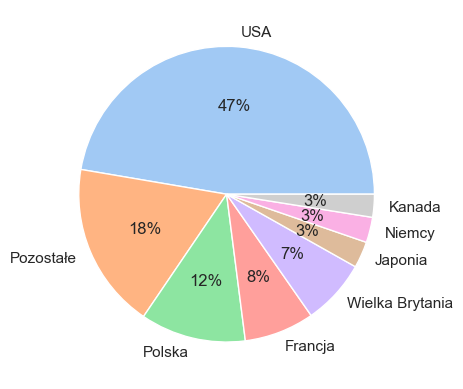

In [49]:
threshold=df.shape[0]*0.02
df_pie = df["Kraj"].dropna().apply(lambda x: x if df["Kraj"].value_counts()[x]>=threshold else "Pozostałe") 
df_pie = df_pie.value_counts().reset_index()
df_pie.columns = ["Kraj", "Liczba"]
plt.pie(df_pie["Liczba"], labels=df_pie["Kraj"], colors=colors, autopct="%.0f%%")
plt.show()

Procentowy udział filmów produkcji polskiej jest dość duży. Można zauważyć też, że wiele filmów pochodzi z pozostałych krajów Europy. Decyduję się sprawdzić rozkład krajów w podziale na kontynenty. Aby to zrobić, najpierw stworzę listy zawierające odpowiednie kraje. 

In [50]:
countries = df["Kraj"].dropna().value_counts().index

ameryka = ["USA", "Kanada", "Meksyk", "Argentyna", "Brazylia", "Chile", "Kolumbia", "Wenezuela", "Paragwaj", "Jamajka", "Gwatemala", "Panama", "Peru", "Kuba", "Urugwaj"]
europa = ["Polska", "Francja", "Wielka Brytania", "Niemcy", "Hiszpania", "Włochy", "Dania", "Rosja", "Szwecja", "Czechy", "Norwegia", "Irlandia", "Belgia", "Austria", "ZSRR",
        "Holandia", "Finlandia", "Węgry", "Czechosłowacja", "Rumunia", "Islandia", "RFN", "Szwajcaria", "Jugosławia", "Grecja", "Bułgaria", "Serbia", "Ukraina", "Chorwacja", 
        "Portugalia", "Estonia", "Bośnia i Hercegowina", "Łotwa", "Słowacja", "Luksemburg", "Macedonia", "Litwa",  "Słowenia", "NRD", "Kosowo", "Cypr", "Fed. Rep. Jugosławii"]
azja = ["Japonia","Indie", "Hongkong", "Izrael", "Korea Południowa","Chiny", "Iran", "Turcja", "Tajwan", "Tajlandia", "Gruzja", "Liban", "Palestyna", "Singapur", "Kazachstan", "Malezja", "Indonezja", "Filipiny", "Wietnam",
      "Arabia Saudyjska", "Zjednoczone Emiraty Arabskie", "Bhutan", "Pakistan", "Kirgistan","Afganistan", "Kambodża"]
australia = ["Australia", "Nowa Zelandia", "Papua Nowa Gwinea"]
afryka = ["Ghana", "Etiopia", "RPA", "Maroko", "Algieria", "Kenia","Tanzania", "Mauretania", "Tunezja", "Egipt", "Sudan"]

countries_check = ameryka + europa + azja + australia + afryka

# sprawdzam czy nie ma duplikatów
for country in countries_check:
    if countries_check.count(country) > 1:
        print("duplikat:", country)

# sprawdzam czy któryś kraj nie został przydzielony do żadnej kategorii
result = []

for country in countries:
    add = True
    for list in countries_check:
        if country in list:
            add = False
            break
    if add:
        result.append(country)

if result:        
    print("Kraje nie przydzielone do żadnej kategorii", result)
else: 
    print("Przypisano wszystkie kraje. Każdy kraj ma swoją kategorię.")

Przypisano wszystkie kraje. Każdy kraj ma swoją kategorię.


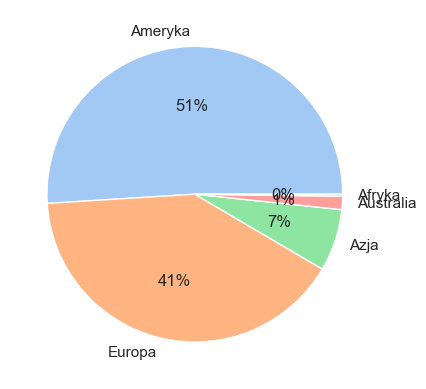

In [51]:
# tworzę słowniki z poszczególnych list przpisując im odpowiednie klucze
d1 = dict.fromkeys(ameryka, "Ameryka")
d2 = dict.fromkeys(europa, "Europa")
d3 = dict.fromkeys(azja, "Azja")
d4 = dict.fromkeys(australia, "Australia")
d5 = dict.fromkeys(afryka, "Afryka")

# tworzę jeden duży słownik z mniejszych
dicts = [d1, d2, d3, d4, d5]
merged_dict = {}
for d in dicts:
    merged_dict.update(d)

# dla każdego kraju z kolumny "Kraj" przypisuję etykietę z kontynentem ze słownika
df["Region"] = df["Kraj"].map(merged_dict)

df_regions = df["Region"].value_counts().reset_index()
df_regions.columns = ["Gatunek", "Liczba"]
plt.pie(df_regions["Liczba"], labels=df_regions["Gatunek"], colors=colors, autopct="%.0f%%")
plt.show()

Widać dużą dysproporcję pomiędzy kontynentami, zatem decyduję się na ręczną rekategoryzację. Tym razem dzielę kraje na następujące kategorie: USA, Europa, Polska i pozostałe.

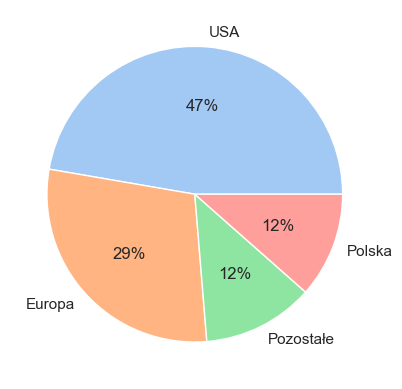

In [52]:
df["Region"] = df["Kraj"].apply(lambda x: x if x in ("USA", "Polska") else ("Europa" if x in europa else "Pozostałe"))
df_countries = df["Region"].value_counts().reset_index()
df_countries.columns = ["Region", "Liczba"]
plt.pie(df_countries["Liczba"], labels=df_countries["Region"], colors=colors, autopct="%.0f%%")
plt.show()

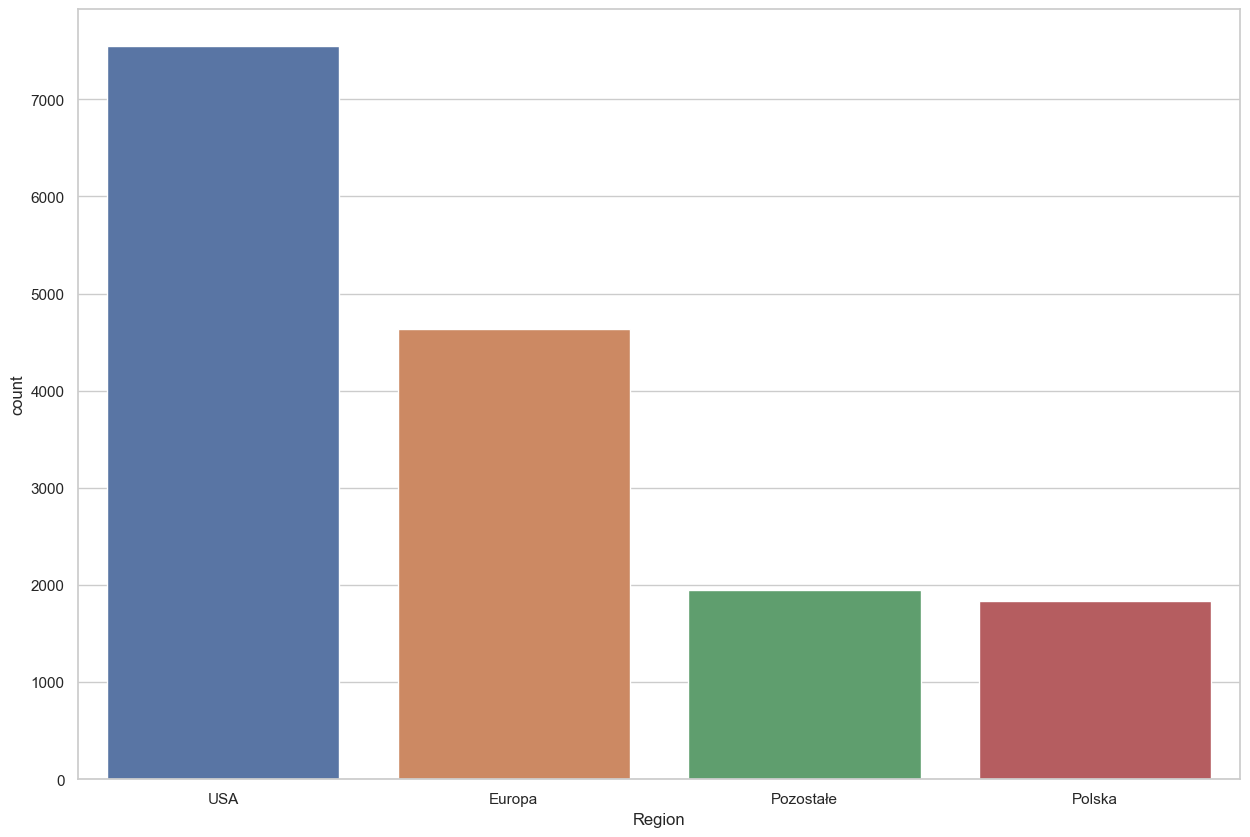

In [53]:
plt.figure(figsize=(15,10))
sns.countplot(x=df["Region"], order=df["Region"].value_counts().index)
plt.show()

Podział ten odzwierciedla w dobry sposób kino międzynarodowe. Filmy wyprodukowane USA znacznie różna się od kina europejskiego, a także filmów z kategorii "pozostałe". Ze względu an to, że jest to polski serwis, istnieje w nim dużo filmów polskiej produkcji, dlatego też można wyodrębnić dla nich osobną kategorię. Poniżej przedstawię, jak region wpływa na ocenę filmu w ujęciu historycznym.

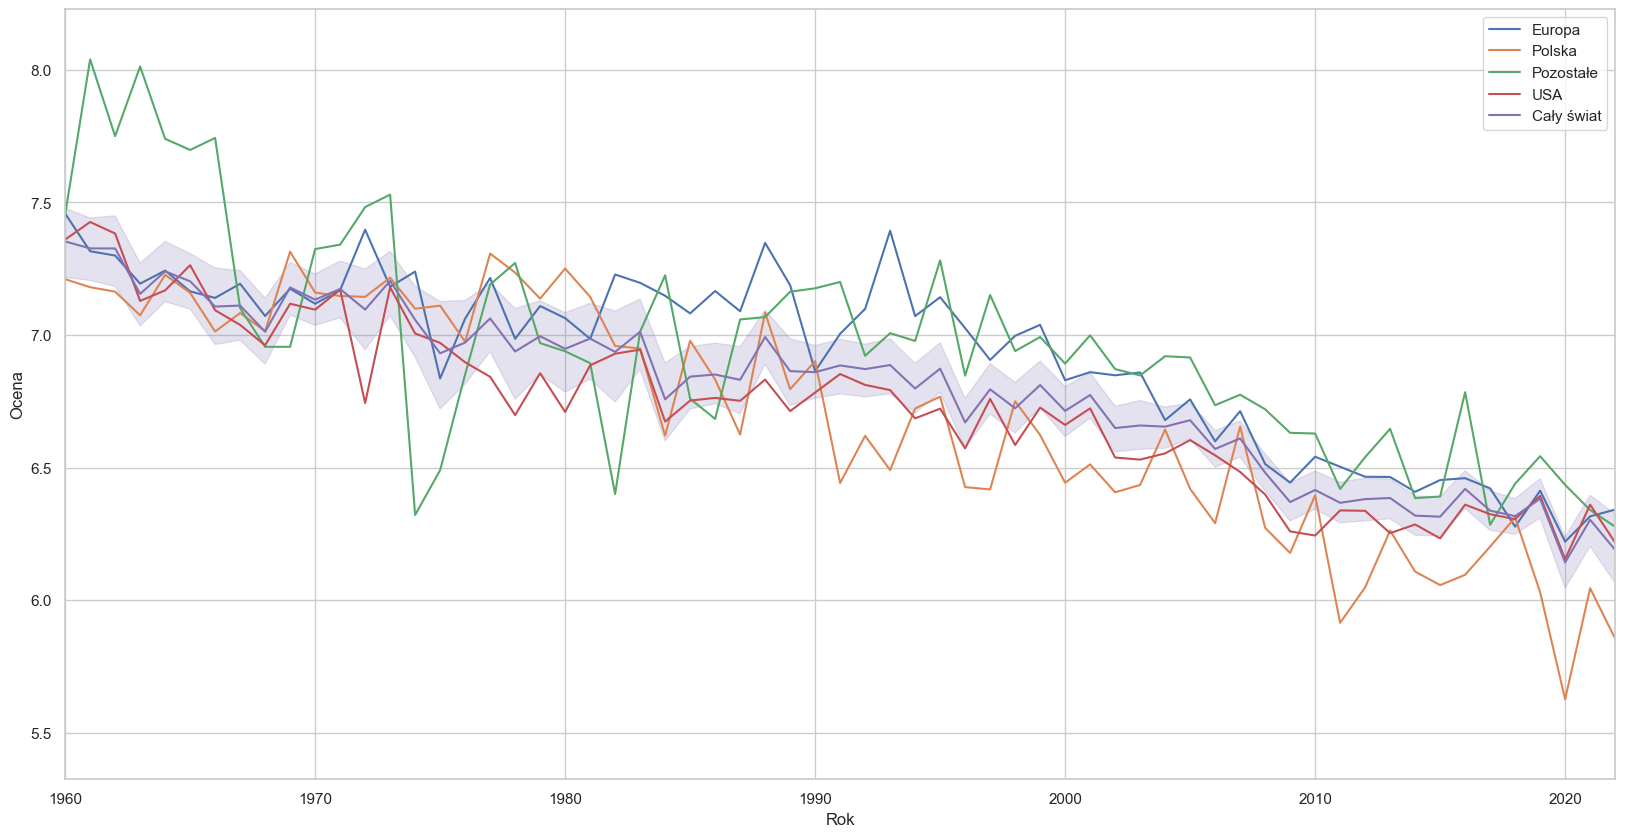

In [54]:
plt.ioff()
df.pivot_table("Ocena", index="Rok", aggfunc="mean", columns="Region").plot(xlim=(1960,2022),figsize=(20,10))
sns.lineplot(x="Rok", y="Ocena", data=df, label="Cały świat")
plt.show(block=True)

Widać, że średnia ocena filmu zarówno dla USA, jak i dla Polski jest niższa niż średnia dla całej bazy danych. W przypadku polskich filmów można wydzielić 2 okresy, lata 1970-1990, gdzie polskie filmy radzą sobie nieco lepiej niż średnia oraz 1990-2020, gdzie poziom ocen znacząco odchylił się w dół od średniej oceny filmów. Może to świadczyć o niskiej jakości polskiej produkcji w ostatnich 30 latach. Filmy z pozostałych kraje, czyli produkcje niszowe, są średnio lepiej oceniane przez użytkowników Filmwebu. Może być to związane z tym, że jeśli film spoza USA czy Europy przebił się na nasz rynek, to musiał być naprawdę dobry i wart obejrzenia. Filmy europejskie oceniane są nieco lepiej niż średnia. Średnie oceny filmów są od wielu lat w trendzie spadkowym, który dodatkowo nasilił się w okolicy roku 2000. Razem z gwałtownym wzrostem przemysłu filmowego po roku 2000, który opisano w punkcje 3.6, spada również średnia ocena filmów.

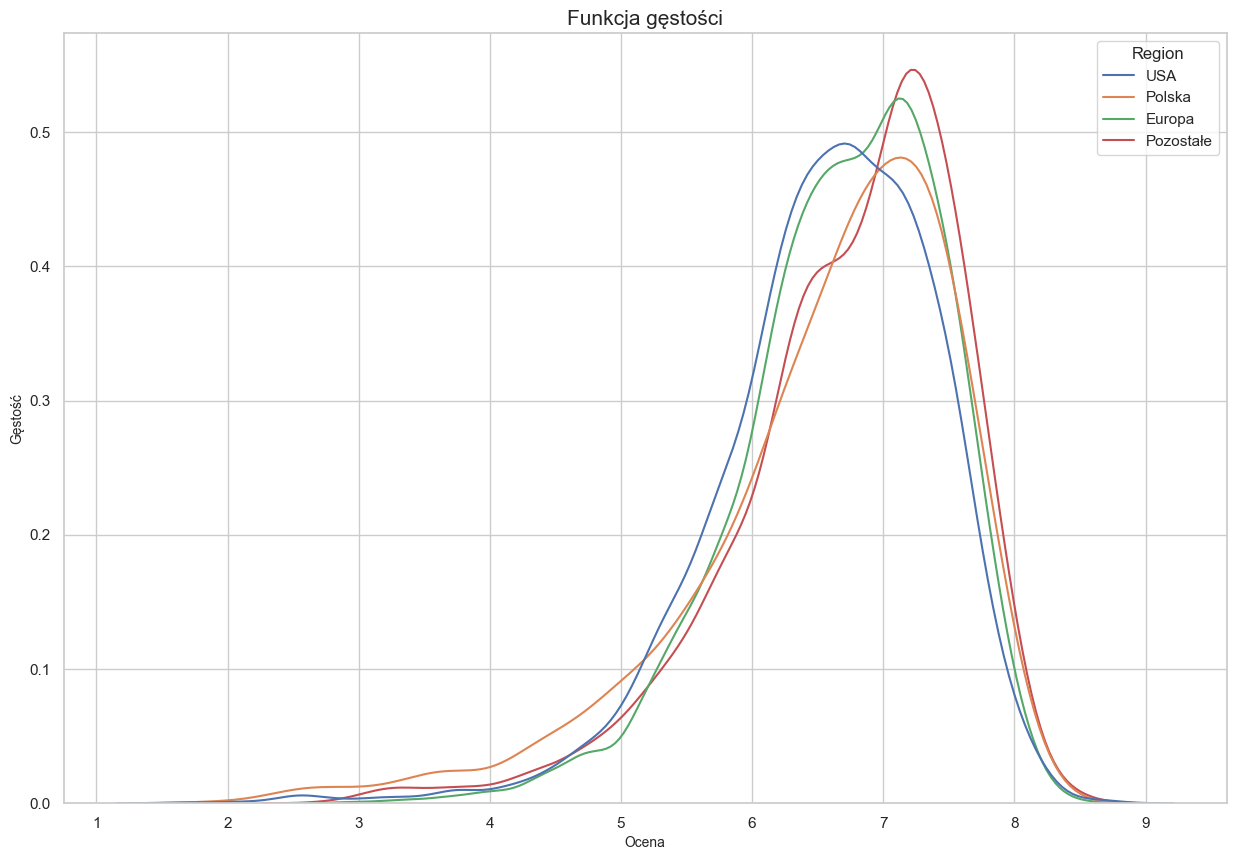

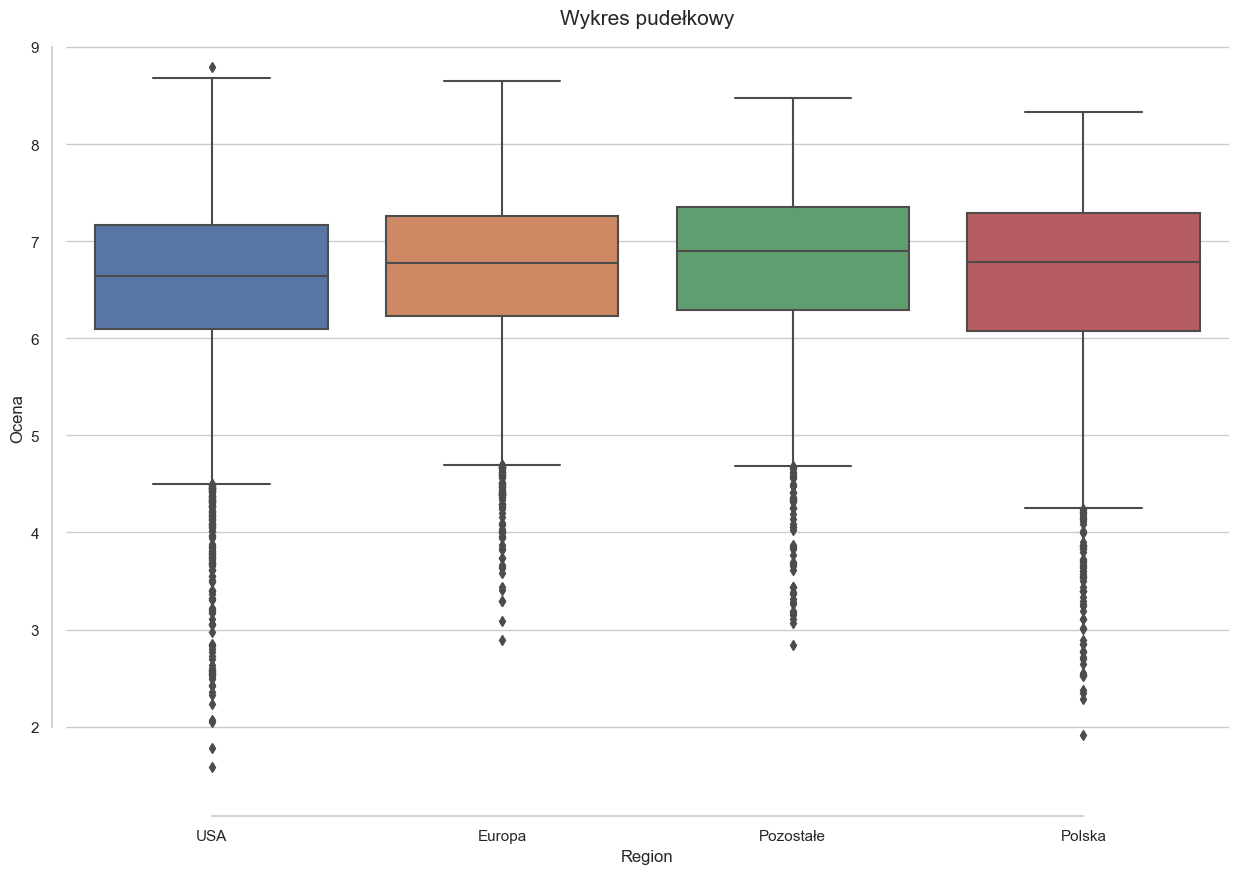

In [55]:
# funkcja gęstości
country_filter = df[["Region", "Ocena"]]
plt.figure(figsize=(15,10))
sns.kdeplot(x="Ocena", hue="Region", data=country_filter, common_norm=False)
plt.title("Funkcja gęstości", fontsize=15)
plt.xlabel("Ocena", fontsize=10)
plt.ylabel("Gęstość", fontsize=10)
plt.show()

# wykres pudełkowy
plt.figure(figsize=(15,10))
sns.boxplot(x="Region", y="Ocena", order=df["Region"].value_counts().iloc[:5].index, data=df)
plt.title("Wykres pudełkowy", fontsize=15)
sns.despine(offset=10, trim=True)
plt.show()

Rozkłady średniej oceny w zależności od regionu są bardzo podobne. Potwierdzają obserwacje z poprzednich wykresów dotyczące lepszej oceny kategorii Europa i Pozostałe od USA i Polska. Widoczny jest też mocny lewy ogon w ocenach filmów polskich. Wpływ na to ma fakt, że najgorsze produkcje z innych krajów nie zdobywają na naszym rynku dużej popularności. 

## 4.2 Analiza zmiennej gatunek

Przeanalizuję podział filmów na gatunki, wyświetlę poniżej podział gatunków na wykresie kołowym, uwzględniając te, których udział wynosi powyżej 2,5%.

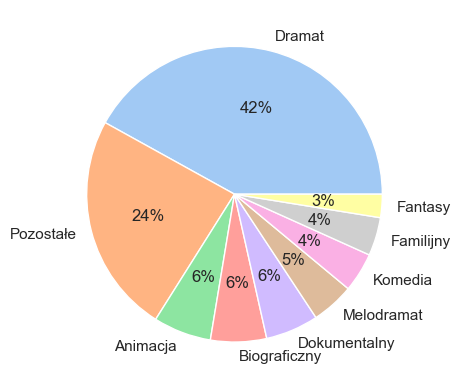

In [56]:
threshold = df.shape[0]*0.025
df_genre = df["Gatunek"].apply(lambda x: x if df["Gatunek"].value_counts()[x]>=threshold else "Pozostałe") 
df_genre = df_genre.value_counts().reset_index()
df_genre.columns = ["Gatunek", "Liczba"]
plt.pie(df_genre["Liczba"], labels=df_genre["Gatunek"], colors=colors, autopct="%.0f%%")
plt.show()

In [57]:
df["Gatunek"].unique()

array(['Thriller', 'Surrealistyczny', 'Kryminał', 'Dramat', 'Akcja',
       'Sci-Fi', 'Komedia', 'Horror', 'Musical', 'Romans', 'Fantasy',
       'Biograficzny', 'Animacja', 'Familijny', 'Dokumentalny',
       'Przygodowy', 'Dramat historyczny', 'Melodramat', 'Kostiumowy',
       'Krótkometrażowy', 'Sensacyjny', 'Komedia rom.', 'Erotyczny',
       'Historyczny', 'Baśń', 'Czarna komedia', 'Dla dzieci',
       'Obyczajowy', 'Western', 'Film-Noir', 'Komedia obycz.',
       'Dramat obyczajowy', 'Satyra', 'Katastroficzny', 'Dreszczowiec',
       'Psychologiczny', 'Polityczny', 'Religijny', 'Gangsterski',
       'Biblijny', 'Komedia kryminalna', 'Wojenny', 'Dramat sądowy',
       'Fabularyzowany dok.', 'XXX', 'Sztuki walki', 'Groteska filmowa',
       'Dokumentalizowany', 'Muzyczny', 'Przyrodniczy', 'Szpiegowski',
       'Sportowy', 'Dla młodzieży', 'Anime'], dtype=object)

Widoczna jest dominacja kategorii "Dramat" i duże rozbicie reszty kategorii, aby uzyskać zbiory bardziej zbliżone do siebie ilościowo, dokonam rekategoryzacji łącząc zbliżone gatunki jak na przykład "Biograficzny" i "Dokumentalny".

In [58]:
genres = df["Gatunek"].dropna().value_counts().index
print("Liczba gatunków:", len(df["Gatunek"].dropna().value_counts().index))

dramat = ["Dramat", "Obyczajowy", "Dramat obyczajowy", "Dramat historyczny", "Dramat sądowy", "Melodramat", "Romans", "Kostiumowy"]
komedia = ["Komedia", "Komedia kryminalna", "Czarna komedia", "Komedia rom.", "Komedia obycz."]
fantasy = ["Fantasy", "Sci-Fi"]
akcja = ["Akcja", "Sensacyjny", "Kryminał", "Sztuki walki", "Katastroficzny", "Gangsterski", "Szpiegowski", "Przygodowy"]
thriller = ["Thriller", "Dreszczowiec", "Horror"]
dokumentalny = ["Dokumentalny", "Biograficzny", "Fabularyzowany dok.", "Przyrodniczy"]
familijny = ["Familijny", "Dla dzieci", "Dla młodzieży"]
animacja = ["Animacja", "Anime"]

genres_check = dramat + komedia + fantasy + akcja + thriller + dokumentalny + familijny + animacja

# sprawdzam czy nie ma duplikatów
for genre in genres_check:
    if genres_check.count(genre) > 1:
        print (genre)

# sprawdzam czy któryś film nie został przydzielony do żadnej kategorii
result =[]

for genre in genres:
    add = True
    for list in genres_check:
        if genre in list:
            add = False
            break
    if add:
        result.append(genre)

matched_sum = df["Gatunek"][~df["Gatunek"].isin(result)].value_counts().sum()
total_sum = df["Gatunek"].value_counts().sum()

print(f"Liczba filmów przydzielonych do nowych kategorii: {matched_sum}/{total_sum} ({100*matched_sum/total_sum:.0f}%)")
print("Filmy nie przydzielone do żadnej kategorii:")

print(df["Gatunek"][df["Gatunek"].isin(result)].value_counts())

Liczba gatunków: 54
Liczba filmów przydzielonych do nowych kategorii: 15335/15966 (96%)
Filmy nie przydzielone do żadnej kategorii:
Western              159
Historyczny           69
Krótkometrażowy       66
Musical               65
Baśń                  50
Film-Noir             46
Surrealistyczny       44
Erotyczny             26
Wojenny               23
Psychologiczny        21
Satyra                19
Muzyczny              16
Biblijny               7
Polityczny             6
Dokumentalizowany      5
Religijny              4
XXX                    2
Sportowy               2
Groteska filmowa       1
Name: Gatunek, dtype: int64


Do nowych kategorii przypisaliśmy 96% filmów, pozostałe pomijamy ze względu na trudności z jednoznacznym dopasowaniem ich do przyjętych kategorii. 

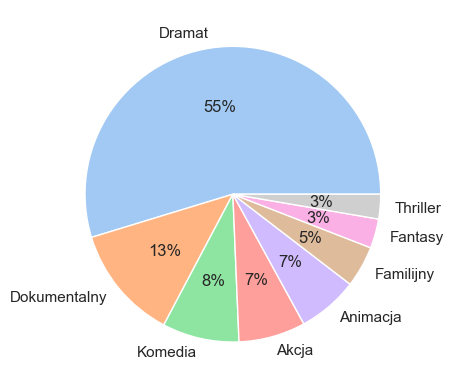

In [59]:
d1 = dict.fromkeys(dramat, "Dramat")
d2 = dict.fromkeys(komedia, "Komedia")
d3 = dict.fromkeys(fantasy, "Fantasy")
d4 = dict.fromkeys(akcja, "Akcja")
d5 = dict.fromkeys(thriller, "Thriller")
d6 = dict.fromkeys(dokumentalny, "Dokumentalny")
d7 = dict.fromkeys(familijny, "Familijny")
d8 = dict.fromkeys(animacja, "Animacja")

dicts = [d1, d2, d3, d4, d5, d6, d7, d8]
merged_dict = {}
for d in dicts:
    merged_dict.update(d)

df["Gatunek"] = df["Gatunek"].map(merged_dict)

df_pie = df["Gatunek"].value_counts().reset_index()
df_pie.columns = ["Gatunek", "Liczba"]
plt.pie(df_pie["Liczba"], labels=df_pie["Gatunek"], colors=colors, autopct="%.0f%%")
plt.show()

Po podziale na nowe kategorie sprawdzam jak oceniane są filmy w danym gatunku. Przedstawiam rozkład średnich ocen filmów na wykresie gęstości prawdopodobieństwa oraz pudełkowym.

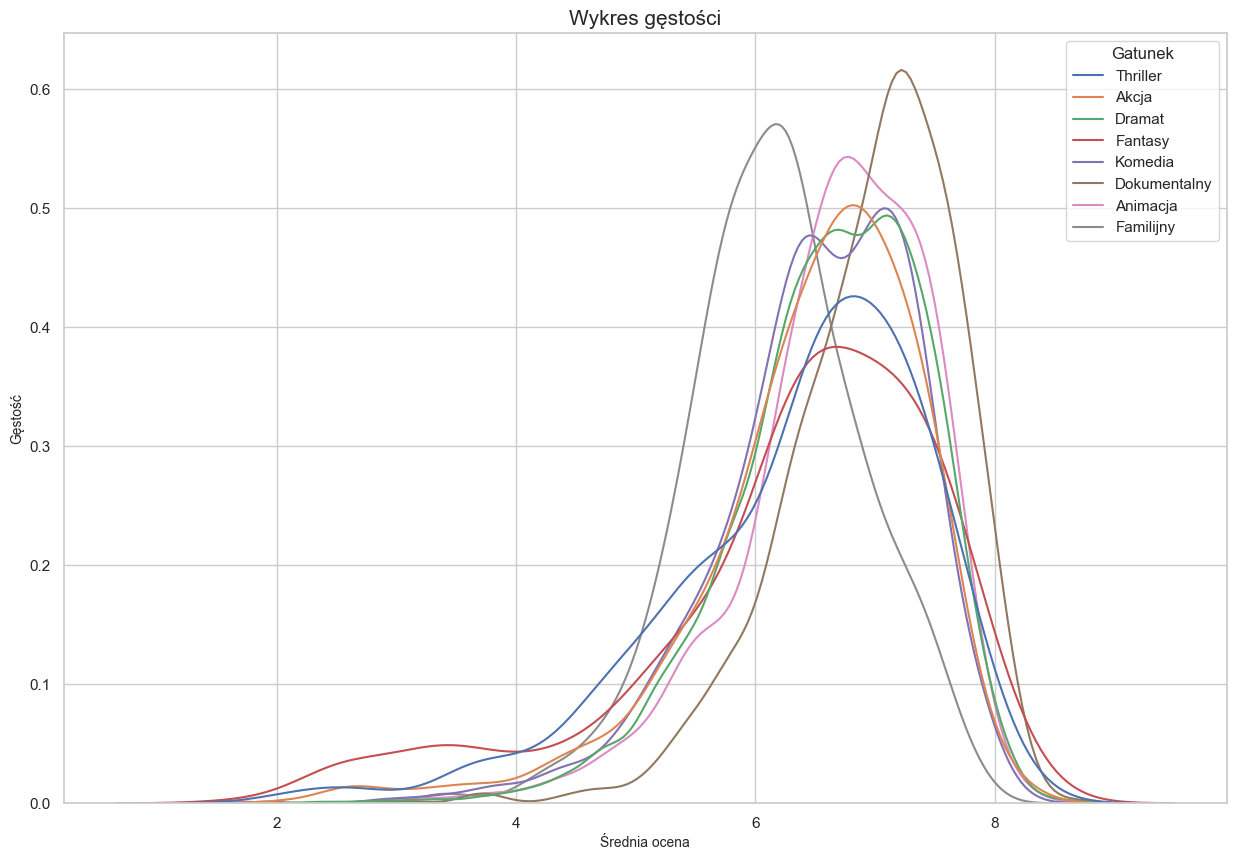

In [60]:
plt.figure(figsize=(15,10))
sns.kdeplot(x="Ocena", hue="Gatunek", data=df[["Gatunek", "Ocena"]], common_norm=False)
plt.title("Wykres gęstości", fontsize=15)
plt.xlabel("Średnia ocena", fontsize=10)
plt.ylabel("Gęstość", fontsize=10)
plt.show()

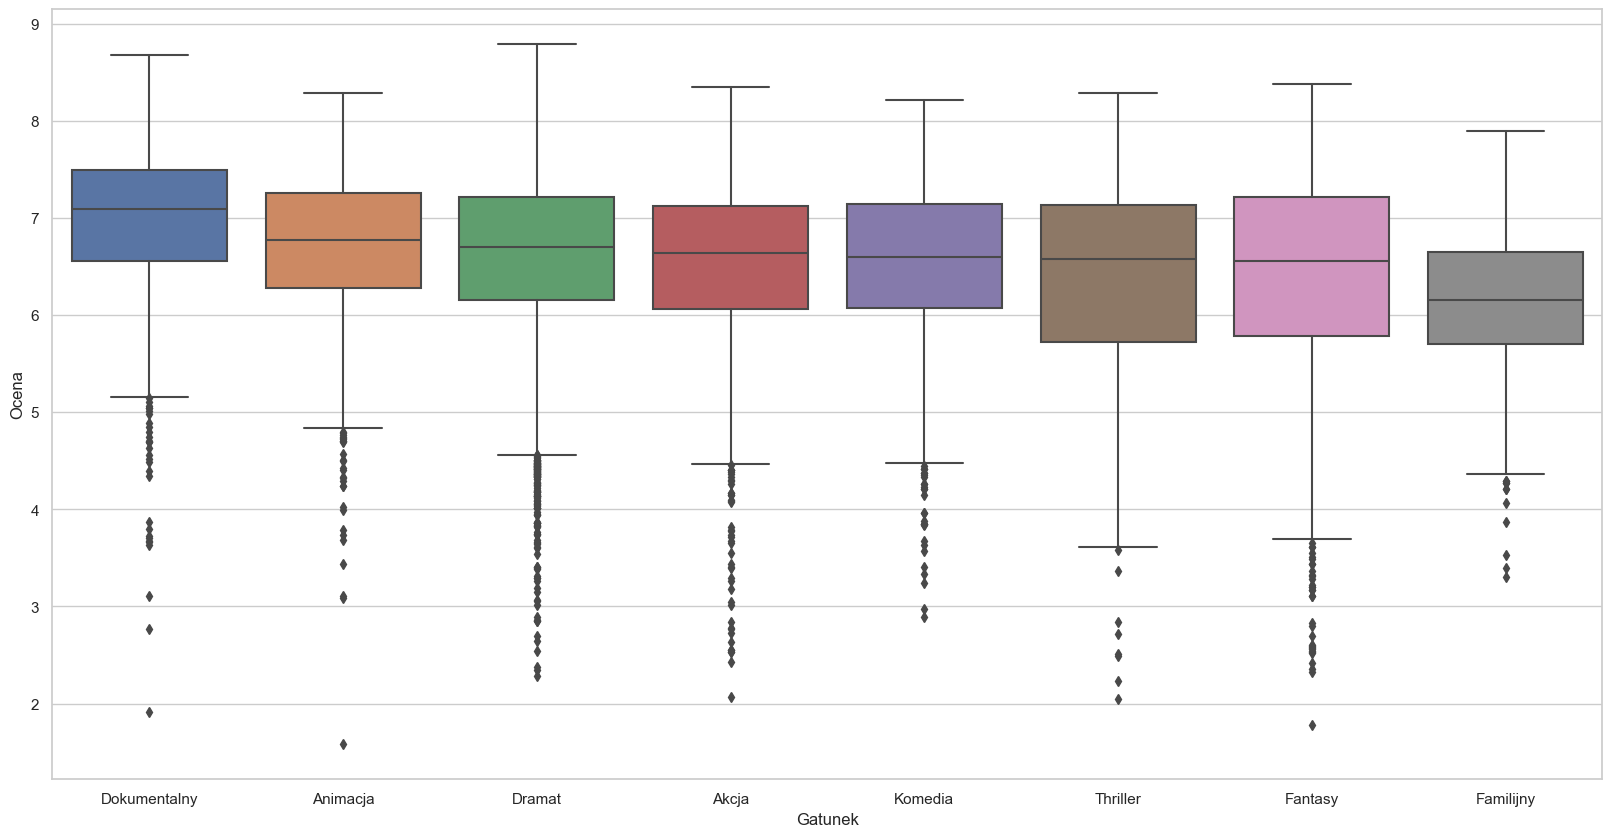

In [61]:
order = df.groupby(["Gatunek"])["Ocena"].median().sort_values(ascending=False).index
plt.figure(figsize=(20,10))
sns.boxplot(x="Gatunek", y="Ocena", data=df, order=order)
plt.show()

Poniżej wyświetlam dystrybuanty dla 4 gatunków, które odbiegają od pozostałych kategorii.

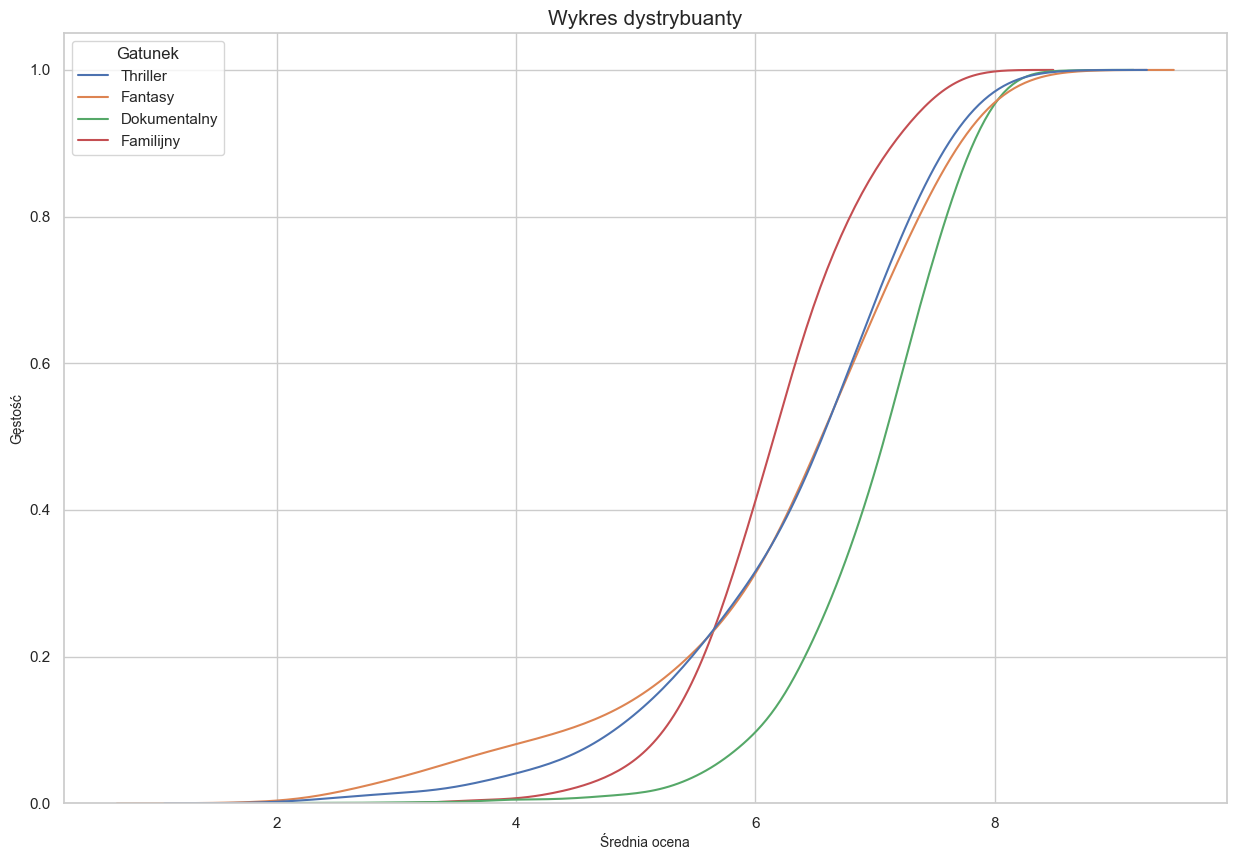

In [62]:
plt.figure(figsize=(15,10))
interesting_genres = ["Familijny", "Dokumentalny", "Fantasy", "Thriller"]
sns.kdeplot(x="Ocena", hue="Gatunek",
            data=df[["Gatunek","Ocena"]][df["Gatunek"].isin(interesting_genres)],
            common_norm=False, cumulative=True)
plt.title("Wykres dystrybuanty", fontsize=15)
plt.xlabel("Średnia ocena", fontsize=10)
plt.ylabel("Gęstość", fontsize=10)
plt.show()

In [63]:
genres_summary = df[["Gatunek","Ocena"]][df["Gatunek"].isin(interesting_genres)].groupby("Gatunek").agg(["mean", "median", "std"])
movies_summary = pd.DataFrame.from_dict({"Ocena": {"mean": rating_mean, "median": rating_median, "std": rating_std}}).T
print("Statystyki dla wszystkich filmów:")
movies_summary

Statystyki dla wszystkich filmów:


mean   median       std
Ocena  6.615896  6.72399  0.853654

In [64]:
print("Statystyki dla gatunków odstających:")
genres_summary

Statystyki dla gatunków odstających:


Ocena                    
                  mean    median       std
Gatunek                                   
Dokumentalny  6.974581  7.089875  0.729486
Familijny     6.156132  6.160950  0.731667
Fantasy       6.297769  6.554990  1.277478
Thriller      6.351007  6.579950  1.093698

Na wykresach widzimy 4 wyróżniające się gatunki filmów od reszty:
1. Familijny - filmy te mają zdecydowanie niższą średnią od reszty, praktycznie nie występują żadne z oceną wyższą od 8, a 40% filmów ma ocenę niższą niż 6.
2. Dokumentalny - filmy mają wyższą średnią od reszty, lewy ogon jest mały, jedynie 10% filmów ma średnią poniżej 6.
3. Fantasy i thrillery - w obu tych gatunkach zauważamy spłaszczony rozkład z silnym lewym ogonem (mediana większa od średniej), świadczący o dużym udziale bardzo słabych filmów ocenianych poniżej 5.

Dla filmów familijnych i dokumentalnych odchylenie standardowe jest mniejsze niż dla całego zbioru danych, a dla fantasy i thrillerów jest większe.

Teraz zbadam jak zmieniała się popularność poszczególnych gatunków w latach.

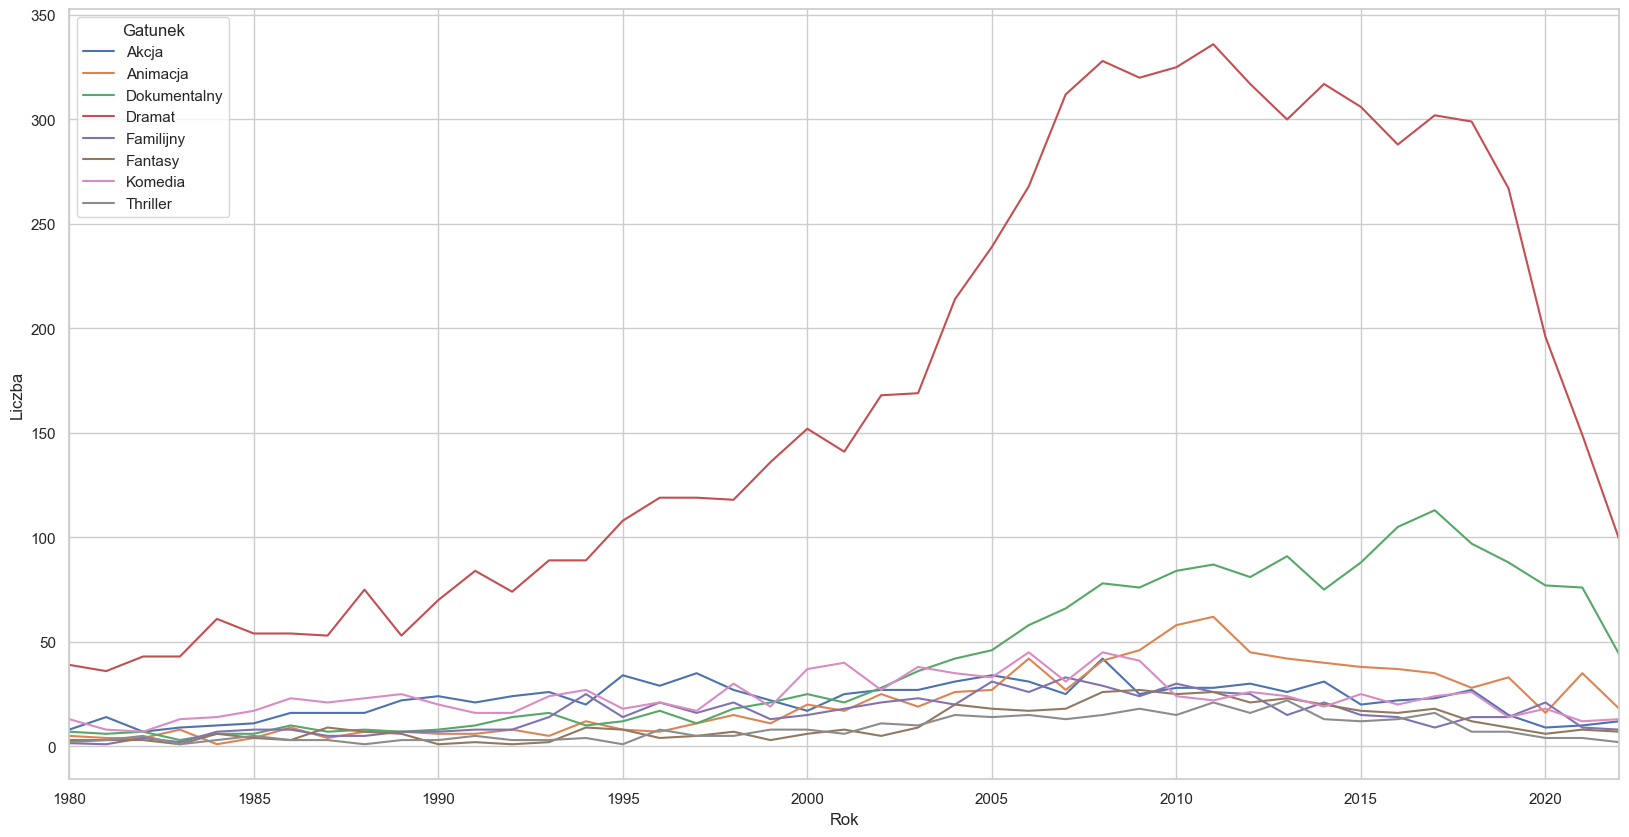

In [65]:
generes = df["Gatunek"].value_counts().index
generes_filter = df.loc[df["Gatunek"].isin(generes)]
generes_filter = generes_filter[["Gatunek", "Rok"]]
generes_filter = generes_filter.groupby(["Gatunek", "Rok"])["Rok"].count().reset_index(name="Liczba")
plt.figure(figsize=(20,10))
ax=sns.lineplot(x="Rok", y="Liczba", hue="Gatunek", data=generes_filter)
ax.set(xlim=(1980,2022))
plt.show()

Z powyższego wykresu widać, że jedynym gatunkiem, którego zachowanie odbiega od pozostałych, są filmy dokumentalne. Po roku 2000 obserwujemy znaczny wzrost popularności tego typu produkcji.

## 4.3 Analiza reżyserów i scenarzystów

Dla kolumny "Scenariusz" przedstawiam poniżej 10 nazwisk z największą liczbą scenariuszy. Króluje tutaj Woody Allen. W pierwszej 10 znajduje się aż 4 Polaków. Ponieważ filmy mogą mieć kliku scenarzystów oraz reżyserów, którzy oddzielni są przecinkami, to biorę pod uwagę jedynie pierwszych.

In [66]:
prolific_screenwriter = df["Scenariusz"].str.split(",", n=1).str[0].value_counts().head(10).reset_index()
prolific_screenwriter.columns = ["Scenariusz", "Liczba filmów"]
prolific_screenwriter.index+=1
prolific_screenwriter

Scenariusz  Liczba filmów
1                Woody Allen             36
2       Krzysztof Kieślowski             35
3             Ingmar Bergman             26
4          Krzysztof Zanussi             23
5                 Luc Besson             23
6             Roman Polański             21
7            Pedro Almodóvar             20
8   Aleksander Ścibor-Rylski             19
9              Werner Herzog             19
10            Akira Kurosawa             18

Analogicznie dla kolumny "Reżyser" przedstawiam 10 reżyserów z największą liczbą wyreżyserowanych filmów. Pierwsze miejsce zajmuje Krzysztof Kieślowski, a zaraz za nim Clint Eastwood i Woody Allen na 2 miejscu.

In [67]:
prolific_director = df["Reżyser"].str.split(",", n=1).str[0].value_counts().head(10).reset_index()
prolific_director.columns = ["Reżyser", "Liczba filmów"]
prolific_director.index+=1
prolific_director

Reżyser  Liczba filmów
1   Krzysztof Kieślowski             42
2            Woody Allen             37
3         Clint Eastwood             37
4          Andrzej Wajda             35
5       Alfred Hitchcock             32
6       Steven Spielberg             30
7        Martin Scorsese             30
8         Roman Polański             27
9         Ingmar Bergman             26
10          Sidney Lumet             26

# 5\. Analiza zależności pomiędzy zmiennymi

## 5.1 Analiza korelacji pomiędzy zmiennymi numerycznymi

Szybkim sposobem na wizualne poszukiwanie zależności pomiędzy zmiennymi z data frame jest funkcja **pairplot** z biblioteki *seaborn*. Pozwala ona na stworzenie wykresów punktowych wszystkich par kolumn numerycznych. Dzięki temu możemy szybko ocenić czy któraś z par wykazuje kolerację. Dla większej czytelności usuwam nieinteresujące mnie kolumny z liczbą pojedynczych ocen od 1 do 10.

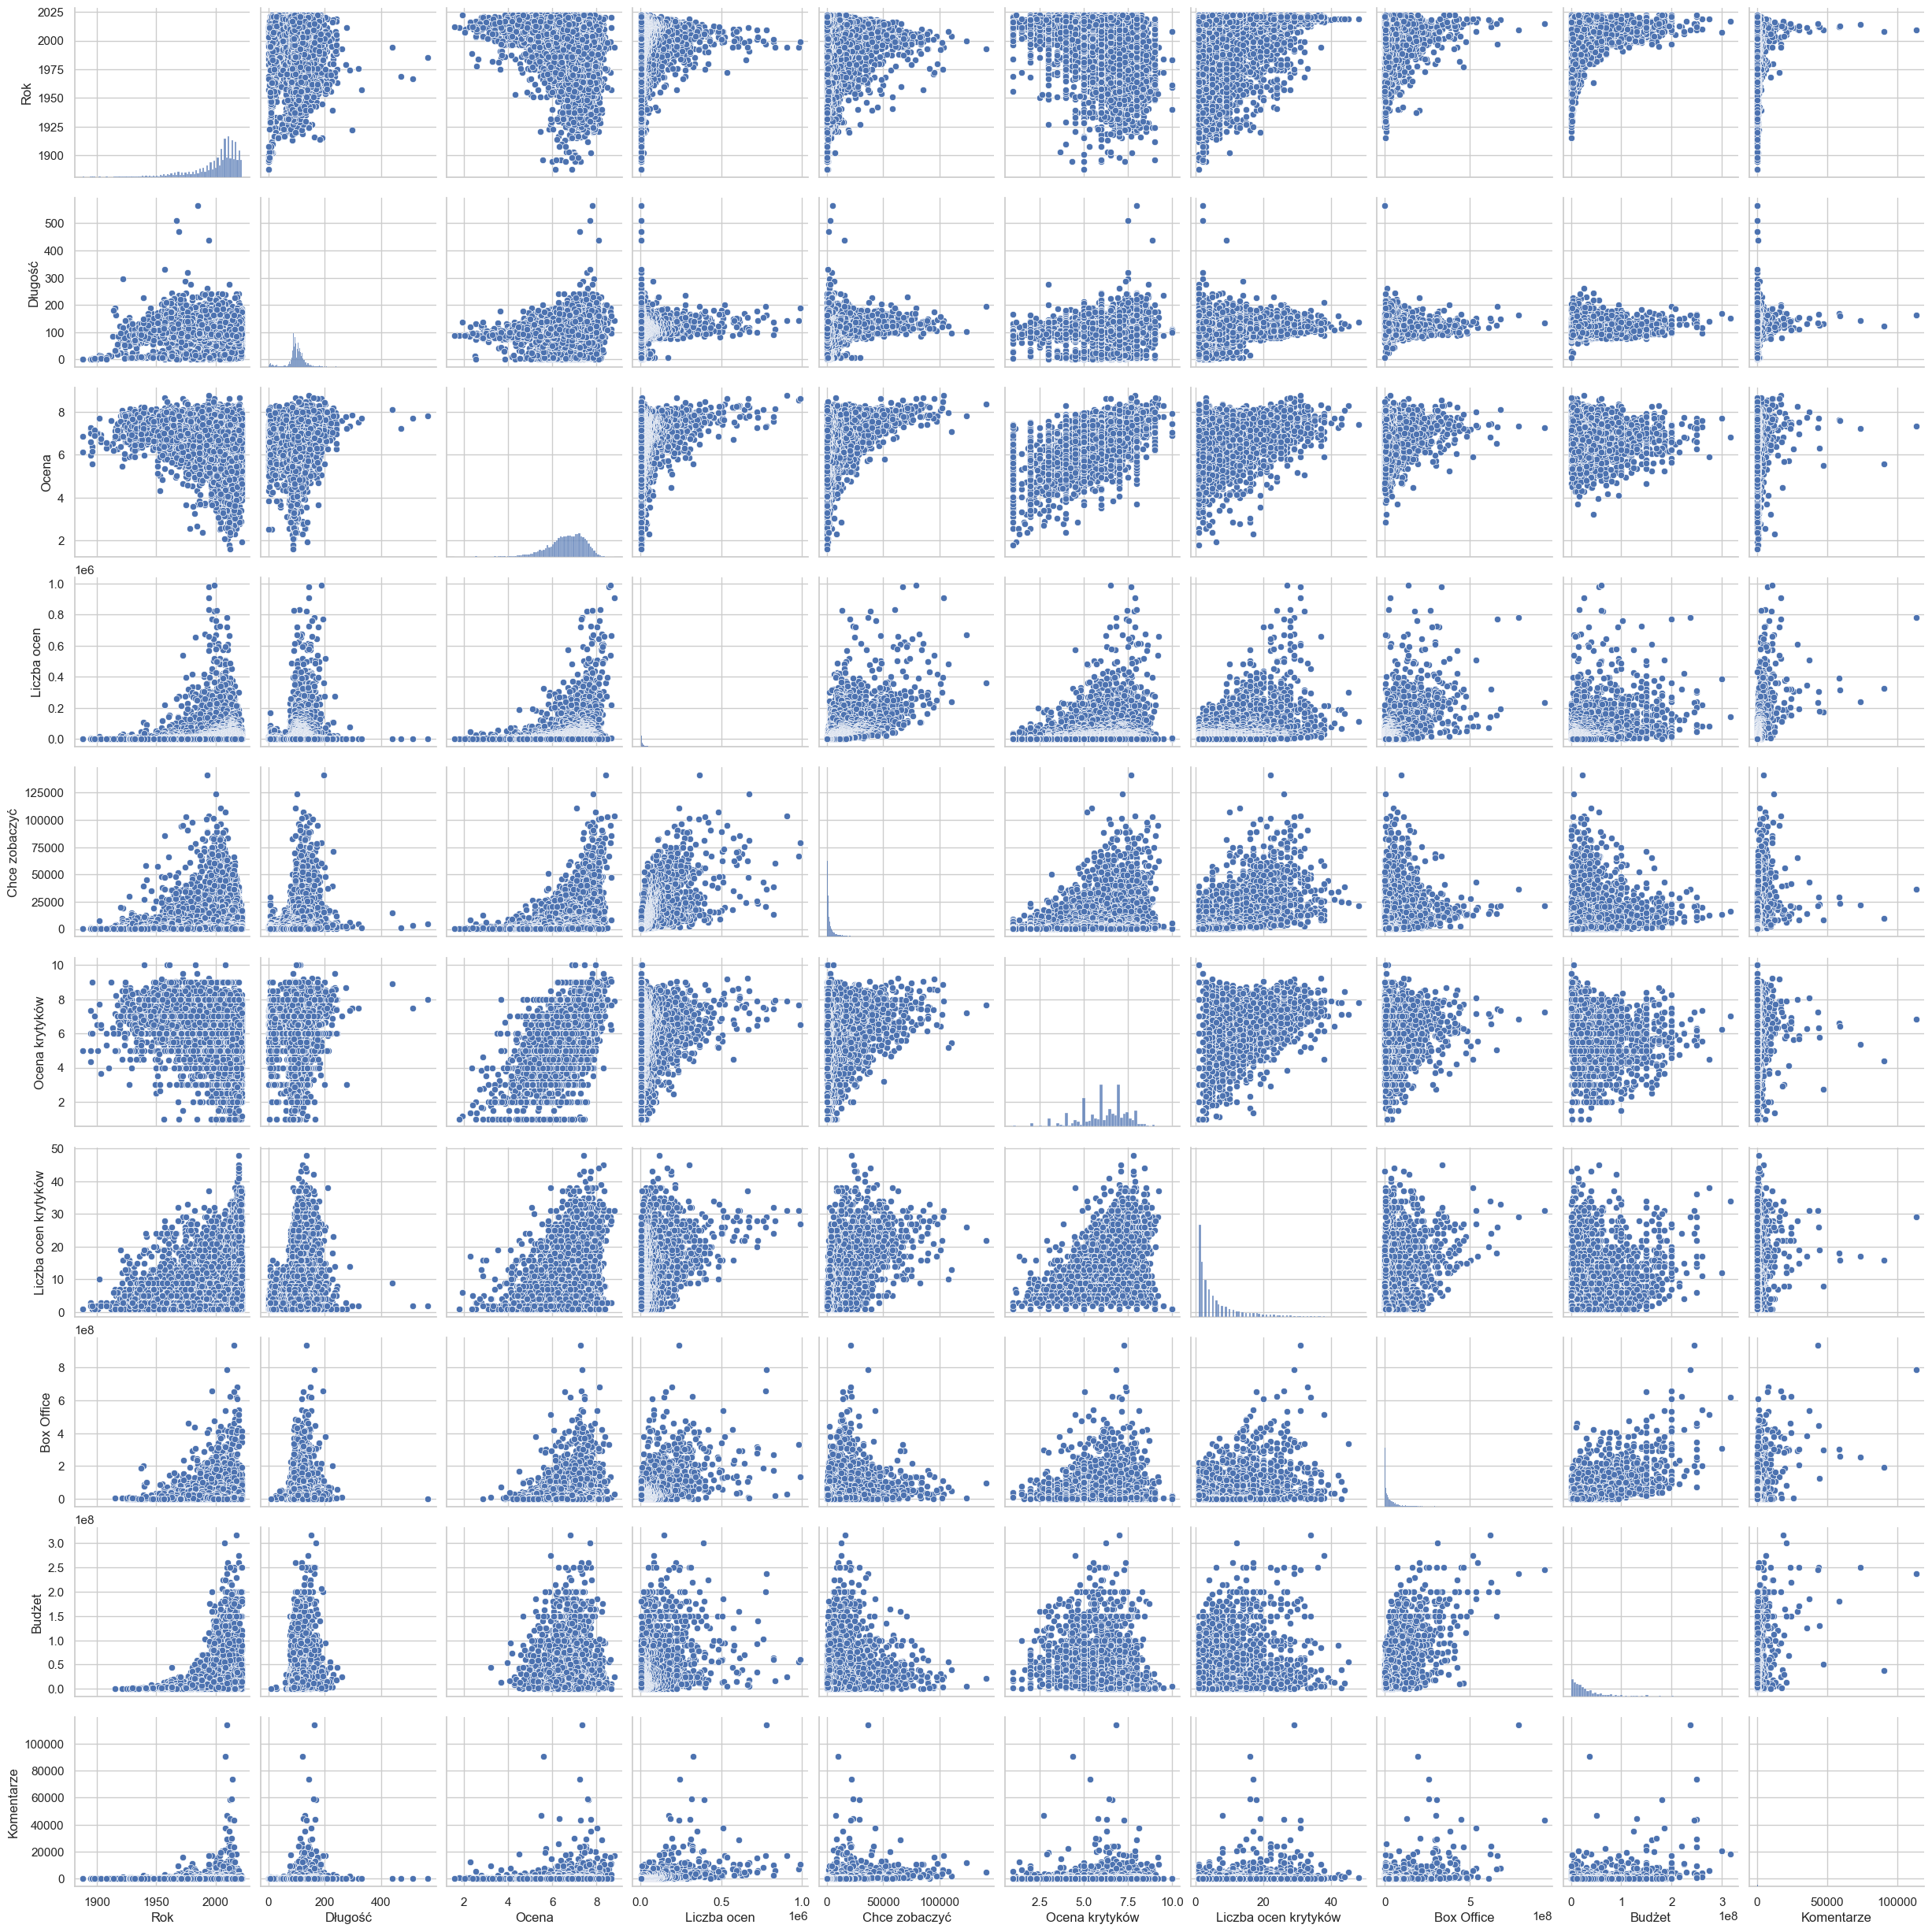

In [68]:
sns.pairplot(df[[col for col in df.columns if not col.isdigit()]])
plt.show()

Widać pewne zależności między niektórymi parami danych. Brak jednak widocznych zależności liniowych, stąd nie będę przeprowadzać obliczeń regresji liniowej. Z tego powodu też obliczanie korelacji na podstawie współczynnika Pearsona jest nieuzasadnione. Korelacja Pearsona działa dobrze, jeśli związek między zmiennymi jest liniowy, jeśli zmienne są w przybliżeniu normalne i nie jest odporny w obecności wartości odstających. Można natomiast skorzystać ze współczynnika Spearmana, który bada monotoniczność zamiast liniowości i jest bardziej odporny na wartości odstające.

Dla zmiennych numerycznych wyświetlam poniżej macierz korelacji.

* Jeśli współczynnik korelacji jest bliższy 1 dla dwóch zmiennych, to zmienne te są do siebie wprost proporcjonalne.
* Jeśli jest bliższa -1, zmienne te są względem siebie odwrotnie proporcjonalne.
* Jeśli wielkość współczynnika korelacji jest mniejsza lub bliższa 0, zmienne prawdopodobnie nie mają silnej zależności względem siebie.

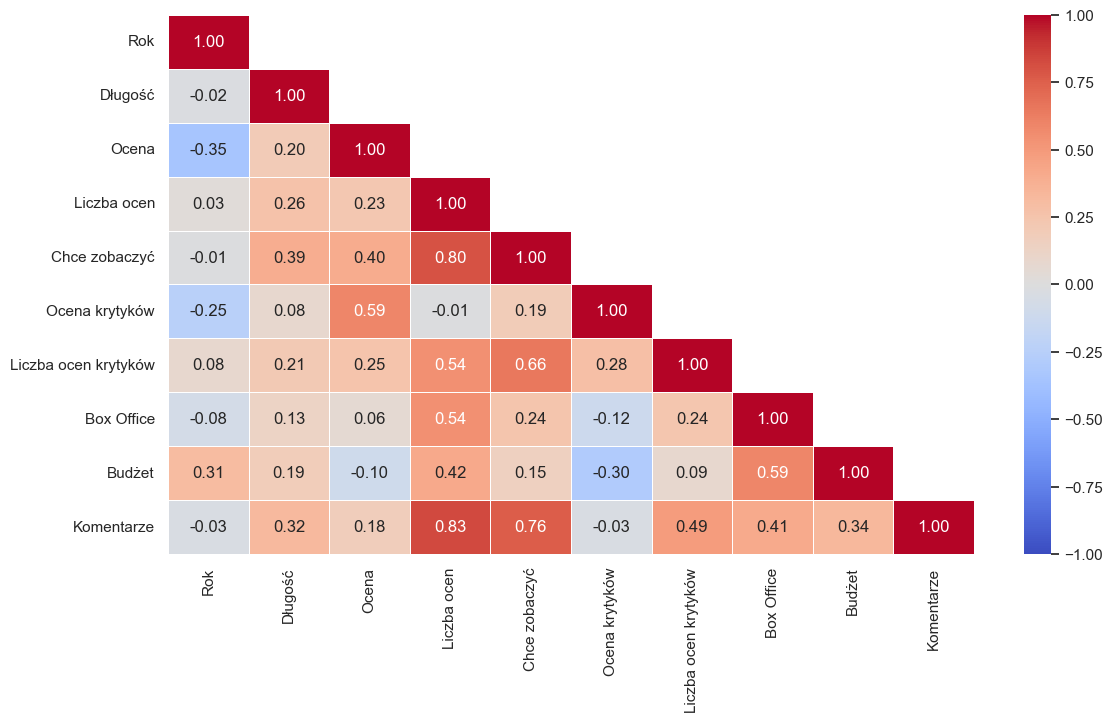

In [69]:
corr = df[[col for col in df.columns if not col.isdigit()]].corr(method="spearman", numeric_only=True)
plt.figure(figsize=(13,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

Z tablicy korelacji można wyciągnąć następujące wnioski:
* korelacja ujemna (odwrotna)
    * Ocena - Rok, Ocena krytyków - Rok: Jak wcześniej zaobserwowano na wykresie średniej ocen filmów w czasie, nowsze filmy są coraz gorzej oceniane. 
    * Budżet - Ocena krytyków: Krytycy filmowi doceniają bardziej filmy niskobudżetowe, w przypadku pozostałych użytkowników korelacja ta jest dużo słabsza.
* korelacja dodatnia
    * Chce zobaczyć - Liczba ocen - Komentarze: Między tymi trzema zmiennymi zachodzi silna korelacja. Widać, że popularne filmy wywołują dużo komentarzy oraz przyciągają kolejnych potencjalnych widzów.
    * Liczba ocen krytyków - Chce zobaczyć: Im więcej ocen krytyków tym więcej osób chce zobaczyć film. Między tymi zmiennymi istnieje silna korelacja, natomiast pomiędzy zmienną Ocena krytyków a Chce zobaczyć zachodzi już słaba korelacja. Liczba ocen krytyków bardziej wpływa na liczbę osób, które chcą zobaczyć film niż sama ocena, którą wystawią filmowi krytycy.
    * Box Office - Budżet - Liczba ocen: Pomiędzy zmiennymi tymi zmiennymi zachodzi średnia korelacja. Większy Box Office implikuje więcej ocen użytkowników, natomiast większy budżet wpływa na to w mniejszym stopniu. Istnieje także pewna korelacja między budżetem a box office, co można było zauważyć to już na wykresach przedstawianych wcześniej, gdzie wnioskowaliśmy, że odpowiednio duży budżet przyniesie sukces filmowi.

## 5.2 Analiza zależności pomiędzy zmiennymi kategorialnymi

Sposobem na szukanie zależności pomiędzy danymi kategorialnymi jest obliczenie V Cramera. Wzór wygląda następująco:

$V = \sqrt{\frac{\chi^2}{n(k - 1)}}$

gdzie:
* $\chi^2$ jest testem niezależności chi-kwadrat,
* $n$ jest łączną liczbą obserwacji,
* $k$ jest mniejszym z rozmiarów tabeli.

Parametr ten przyjmuje wartości w przedziale [0,1], gdzie 0 to brak korelacji, a 1 to pełna korelacja. Poniżej definiuje funkcje **Cramers_V** obliczającą V Cramera i **df_Cramers_V**, która może obliczyć ten współczynnik dla całego DataFrame. Poniżej pokazuję obliczone współczynniki dla wybranych kategorii w formie heatmapy.

In [70]:
def Cramers_V(tab):
    a = stats.chi2_contingency(tab)[0]/sum(tab.sum())
    b = min(tab.shape[0]-1, tab.shape[1]-1)
    return(np.sqrt(a/b))

def df_Cramers_V(tab):
    results = []
    for m in tab:
        row = []
        for n in tab:
            cross_tab = pd.crosstab(tab[m].values, tab[n].values)
            row.append(Cramers_V(cross_tab))
        results.append(row)
    return pd.DataFrame(results, columns=tab.columns, index=tab.columns)

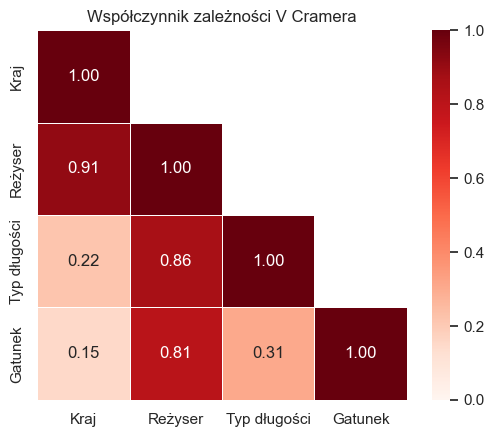

In [71]:
cramer = df_Cramers_V(df[["Kraj", "Reżyser", "Typ długości", "Gatunek"]])
mask = np.zeros_like(cramer)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(cramer, mask=mask, cmap="Reds", vmin=0, vmax=1, linewidths=.5,
            annot=True, fmt=".2f", square=True).set(title="Współczynnik zależności V Cramera")
plt.show()

Istnieje mocna zależność pomiędzy reżyserem a krajem produkcji, a także reżyserem i gatunkiem. Wysoki współczynnik jest również pomiędzy reżyserem a typem filmu (długo-, średnio- i krótkometrażowy). Widać zatem, że reżyserowie trzymają się zazwyczaj jednego kraju, gatunku i długości filmu. Nie ma natomiast zależności między pozostałymi danymi, czyli w jednym kraju produkuje się filmy w różnych gatunkach i długościach, a filmy w danym gatunku mogą mieć różne długości.

# 6\. Podsumowanie i wnioski

Podczas analizy eksploracyjnej można było zauważyć pewne cechy charakterystyczne dla ocenianych filmów.
* Skala ocen 1-10 jest w rzeczywistości używana głównie w zakresie 5-10.
* Są gatunki, których rozkład ocen jest widocznie lepszy (dokumentalne) lub gorszy (familijne) od rozkładu wszystkich ocen.
* Przy podziale na regiony również można zaobserwować lepsze (Europa i pozostałe) i gorsze (USA i Polska) wyniki od średniej.
* Dla wykresów punktowych dla danych numerycznych widoczne są pewne zależności, aczkolwiek nie są one liniowe i charakteryzują się dużym rozrzutem.

Ponieważ dane, takie jak kraj i gatunek filmu, mają przełożenie na jego ocenę, można tę wiedzę wykorzystać do stworzenia modelu uczenia maszynowego. Tym tematem zajmę się w kolejnej części projektu, eksportuję zatem przetworzone podczas analizy dane do nowego pliku CSV.

In [72]:
df.to_csv(
        "wyniki.csv",
        encoding="utf-8",
        index=False,
        header=df.columns,
        sep=";",
    )